In [54]:
import sys
import os

# Add the root directory to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

from dsa_analysis import load_config, visualize
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import interpolate
import main
from main import RNNLayer
import ast
import DSA
import copy
from notebooks.utils_mamba import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load config

In [55]:
config = load_config("../config.yaml")
taskset = "PDM"

### Get dissimilarities

#### Computation dynamics

In [56]:
path = f"../data/dissimilarities/{taskset}/"
df = get_dataframe(path, taskset)
groups_base = ["untrained", "master"]
groups_selected = ["pretrain_basic_frozen", "pretrain_frozen", "pretrain_unfrozen"]
df_selected = df[df["group1"].isin(groups_base) & df["group2"].isin(groups_selected)]

In [57]:
def discriminate_df(df_selected, groups_base, criteria):
    for measure in measures:
        fig, axes = plt.subplots(
            nrows=1, ncols=2, figsize=(20, 10), sharex=True, sharey=True
        )

        # Iterate over each group pair
        for group in groups_base:
            ax = axes[groups_base.index(group)]
            # Plot a violin plot for the dissimilarity distribution
            sns.violinplot(
                data=df_selected[
                    (df_selected["group1"] == group)
                    & (df_selected["measure"] == measure)
                ],
                x=criteria,
                y="dissimilarity",
                hue="group2",
                ax=ax,
                inner="quart",
                palette="Set2",
            )
            ax.set_title(f"{group}", fontsize=8)
            ax.set_xlabel("")
            ax.set_ylabel("")

        # Adjust layout
        plt.suptitle(
            f"Distribution of Dissimilarities Across Groups for Metric : {measure}",
            fontsize=16,
        )
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

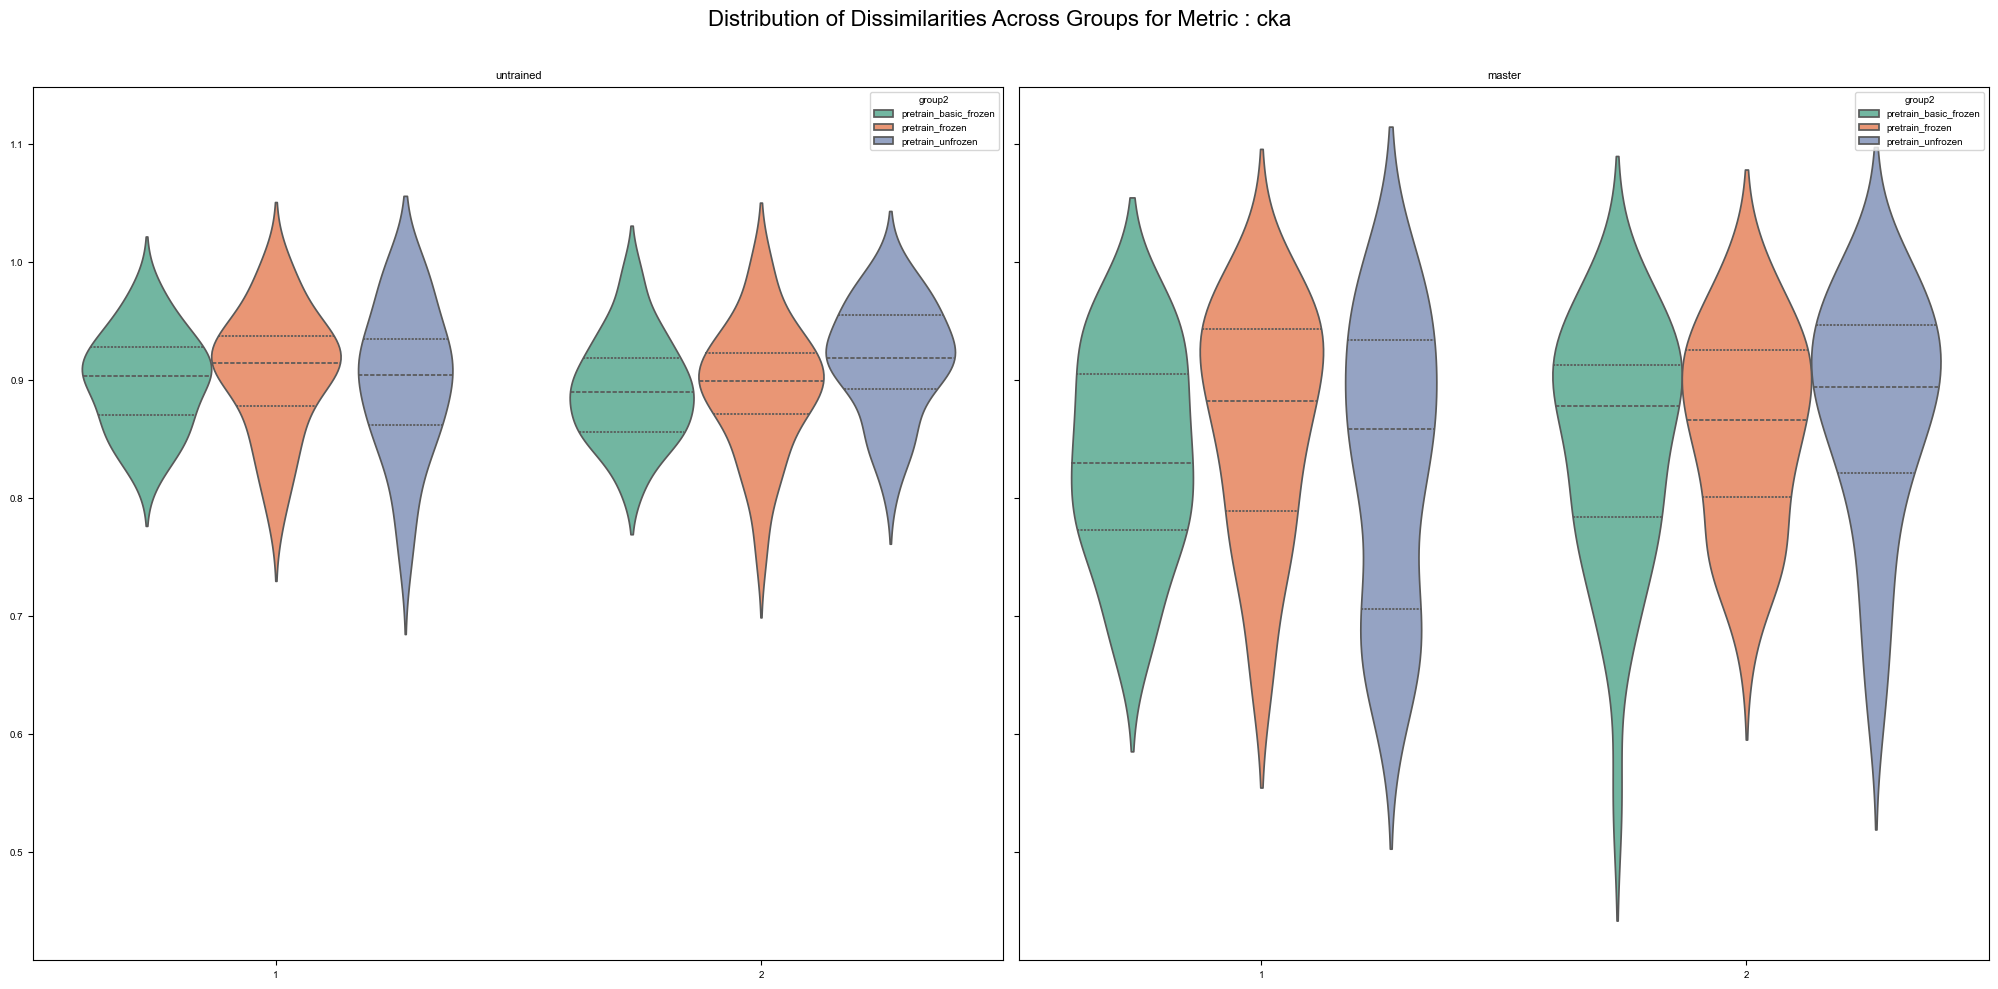

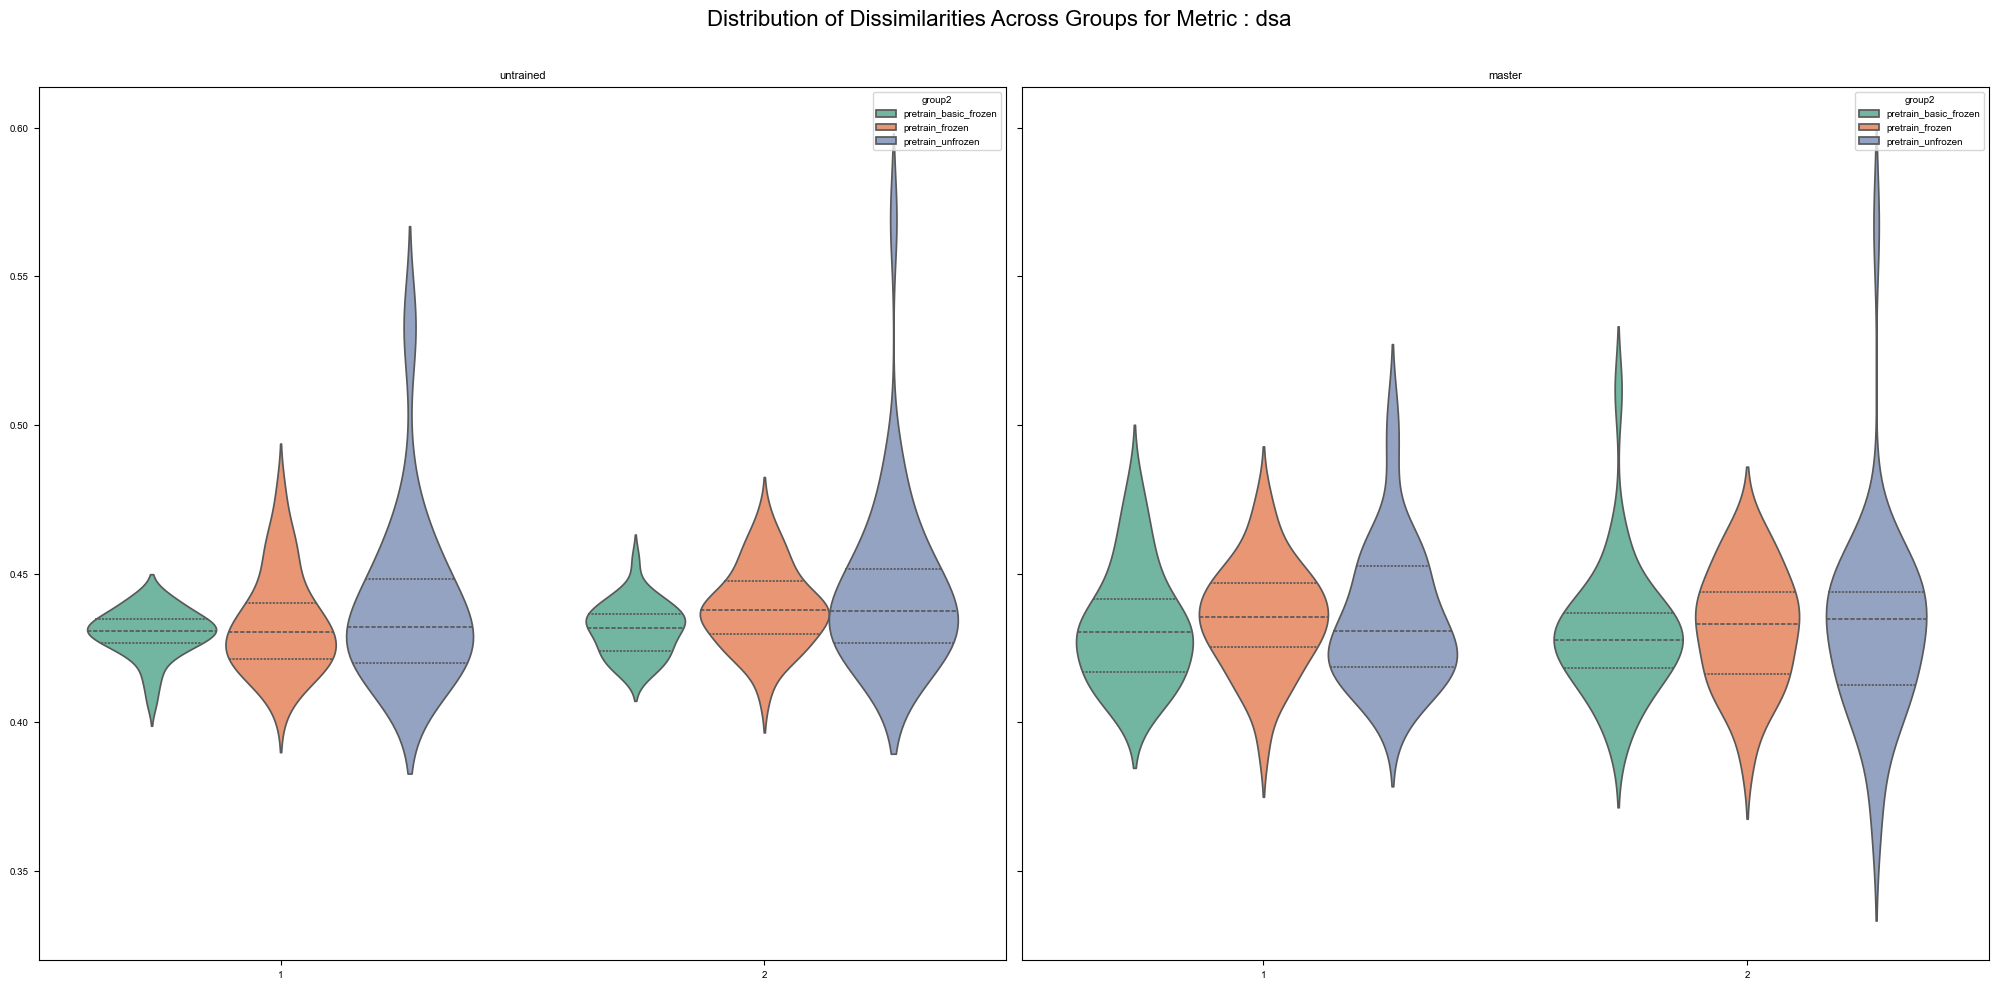

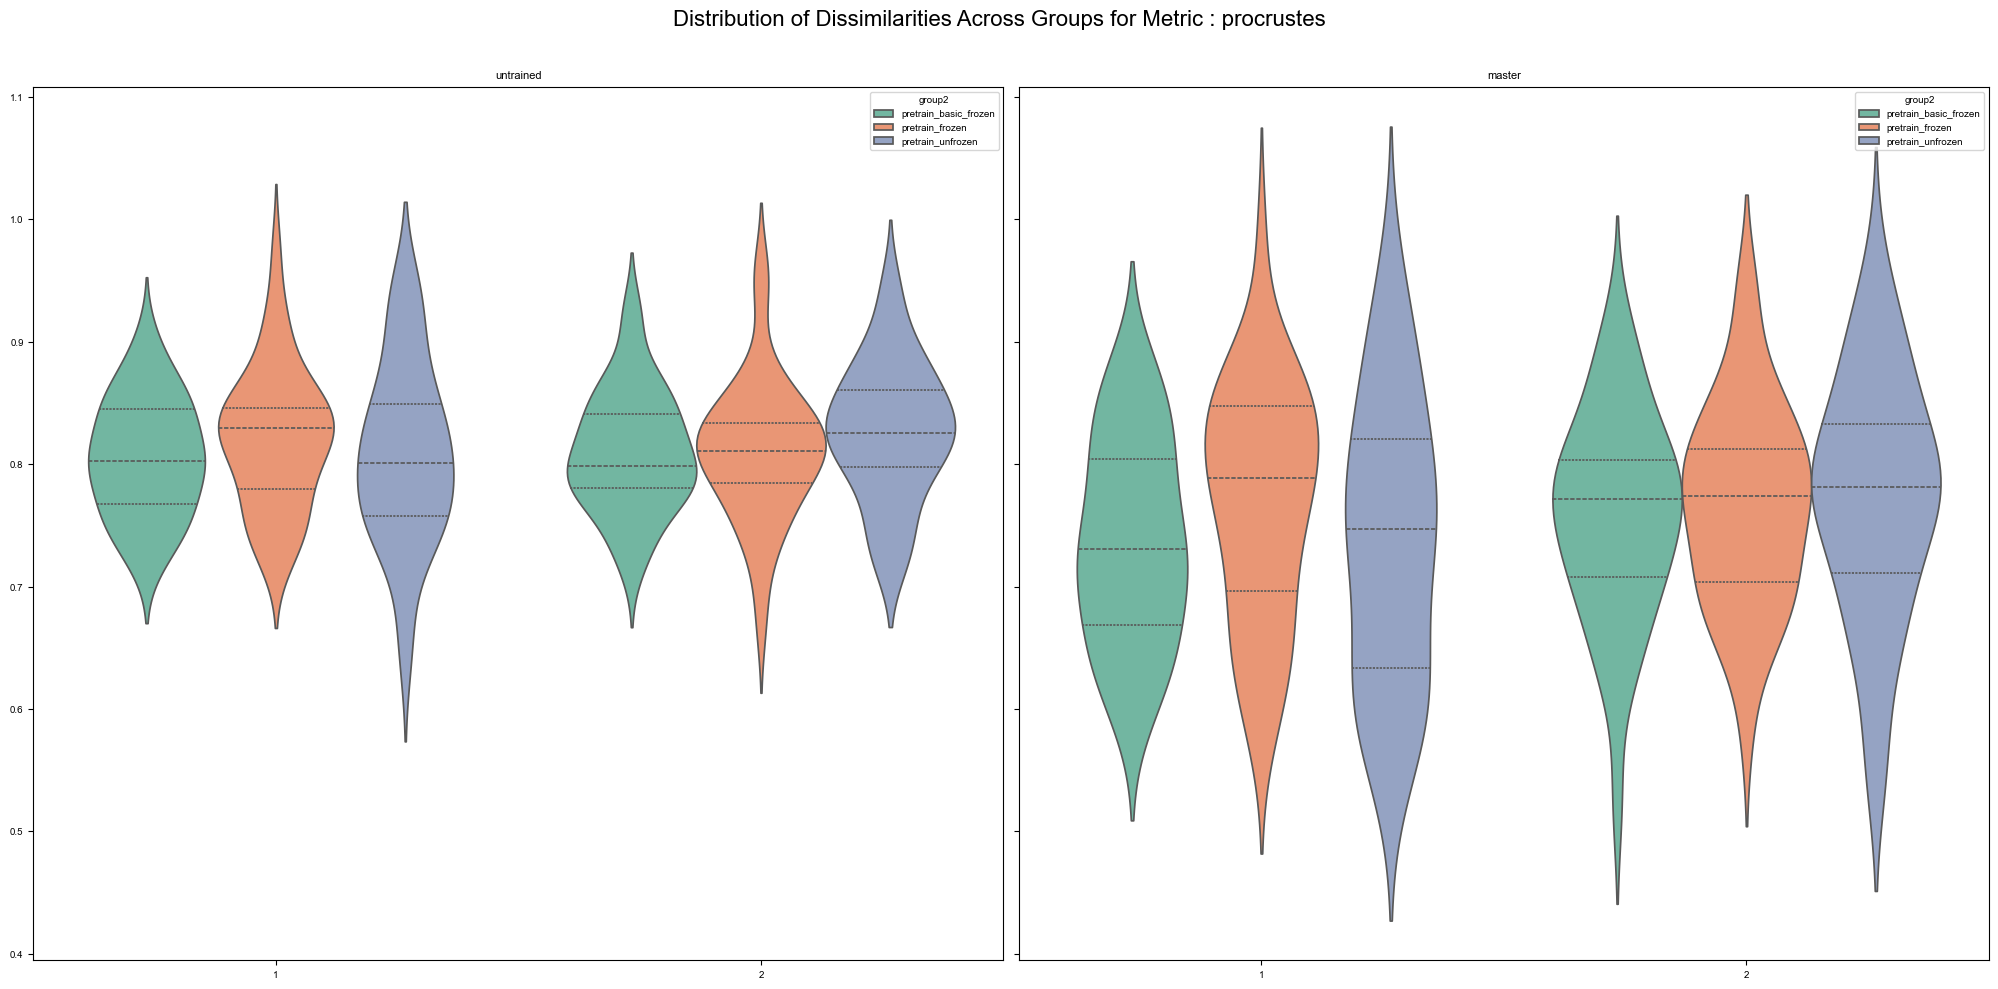

In [58]:
discriminate_df(df_selected, groups_base, criteria="n_layers")

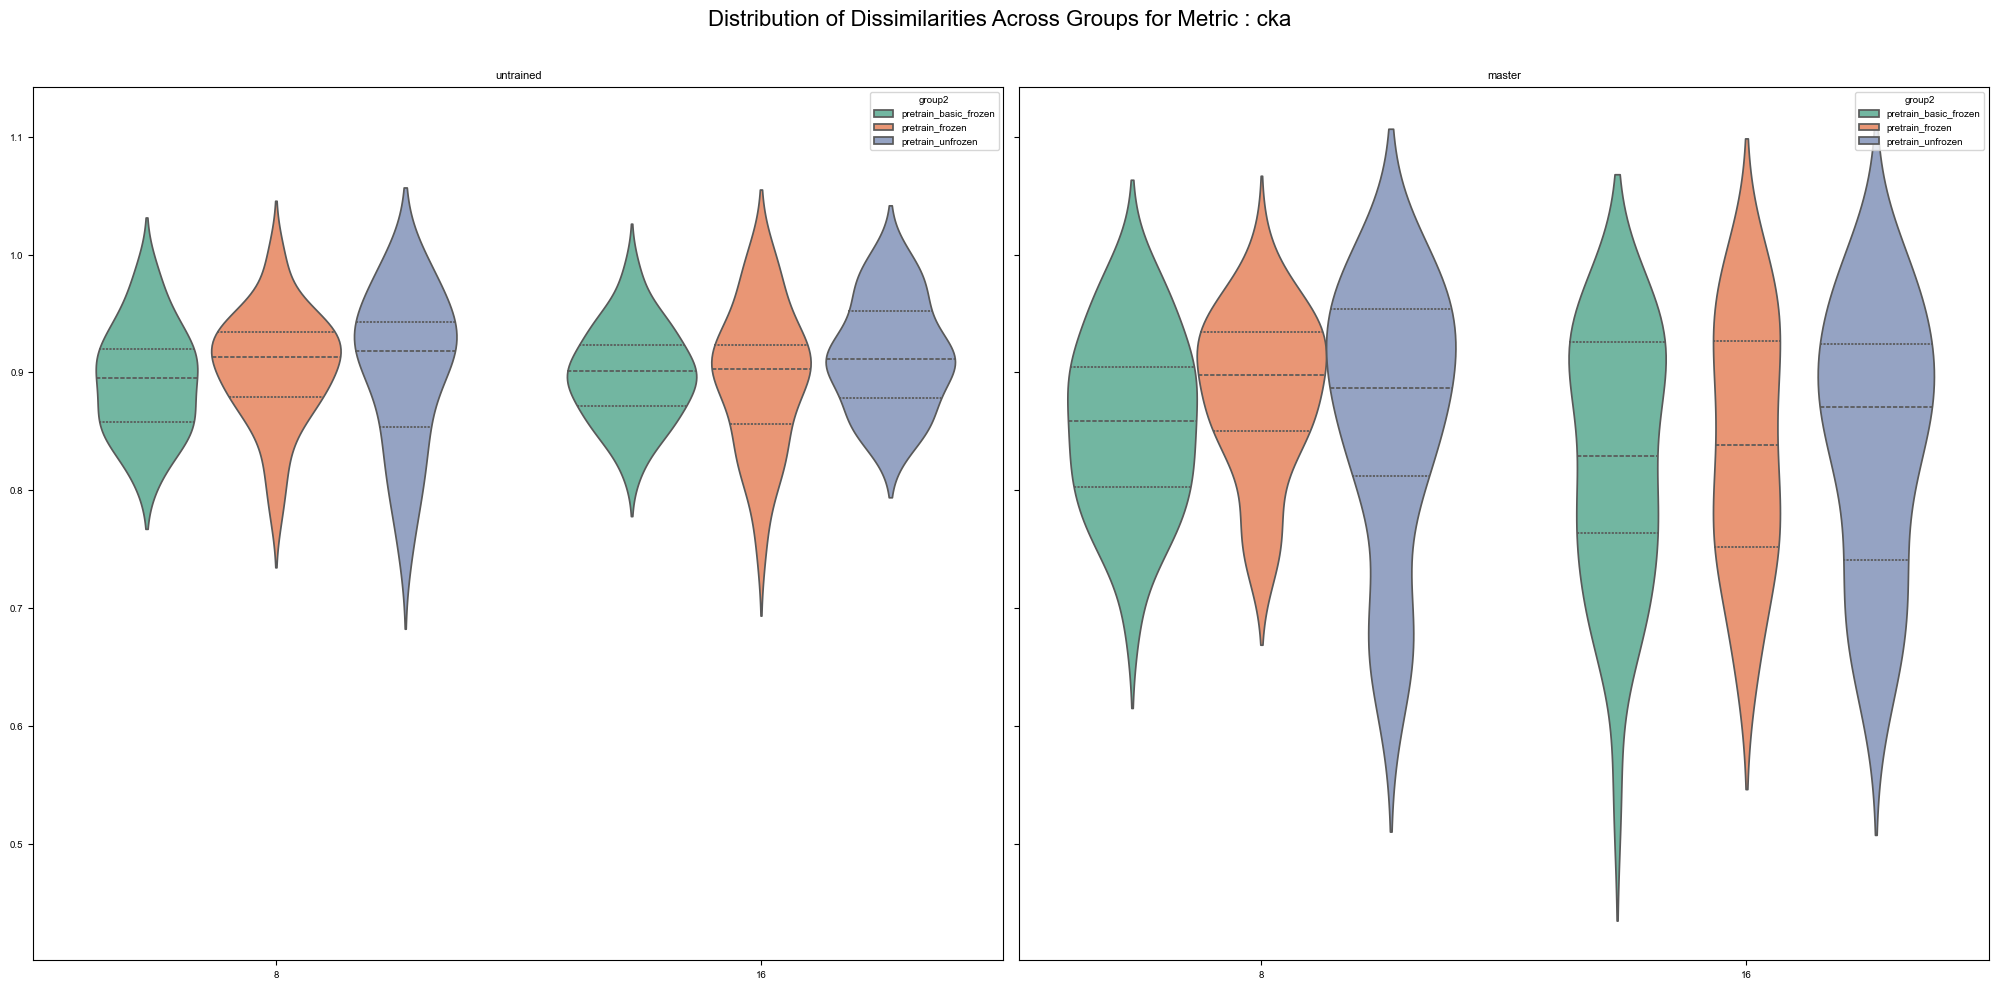

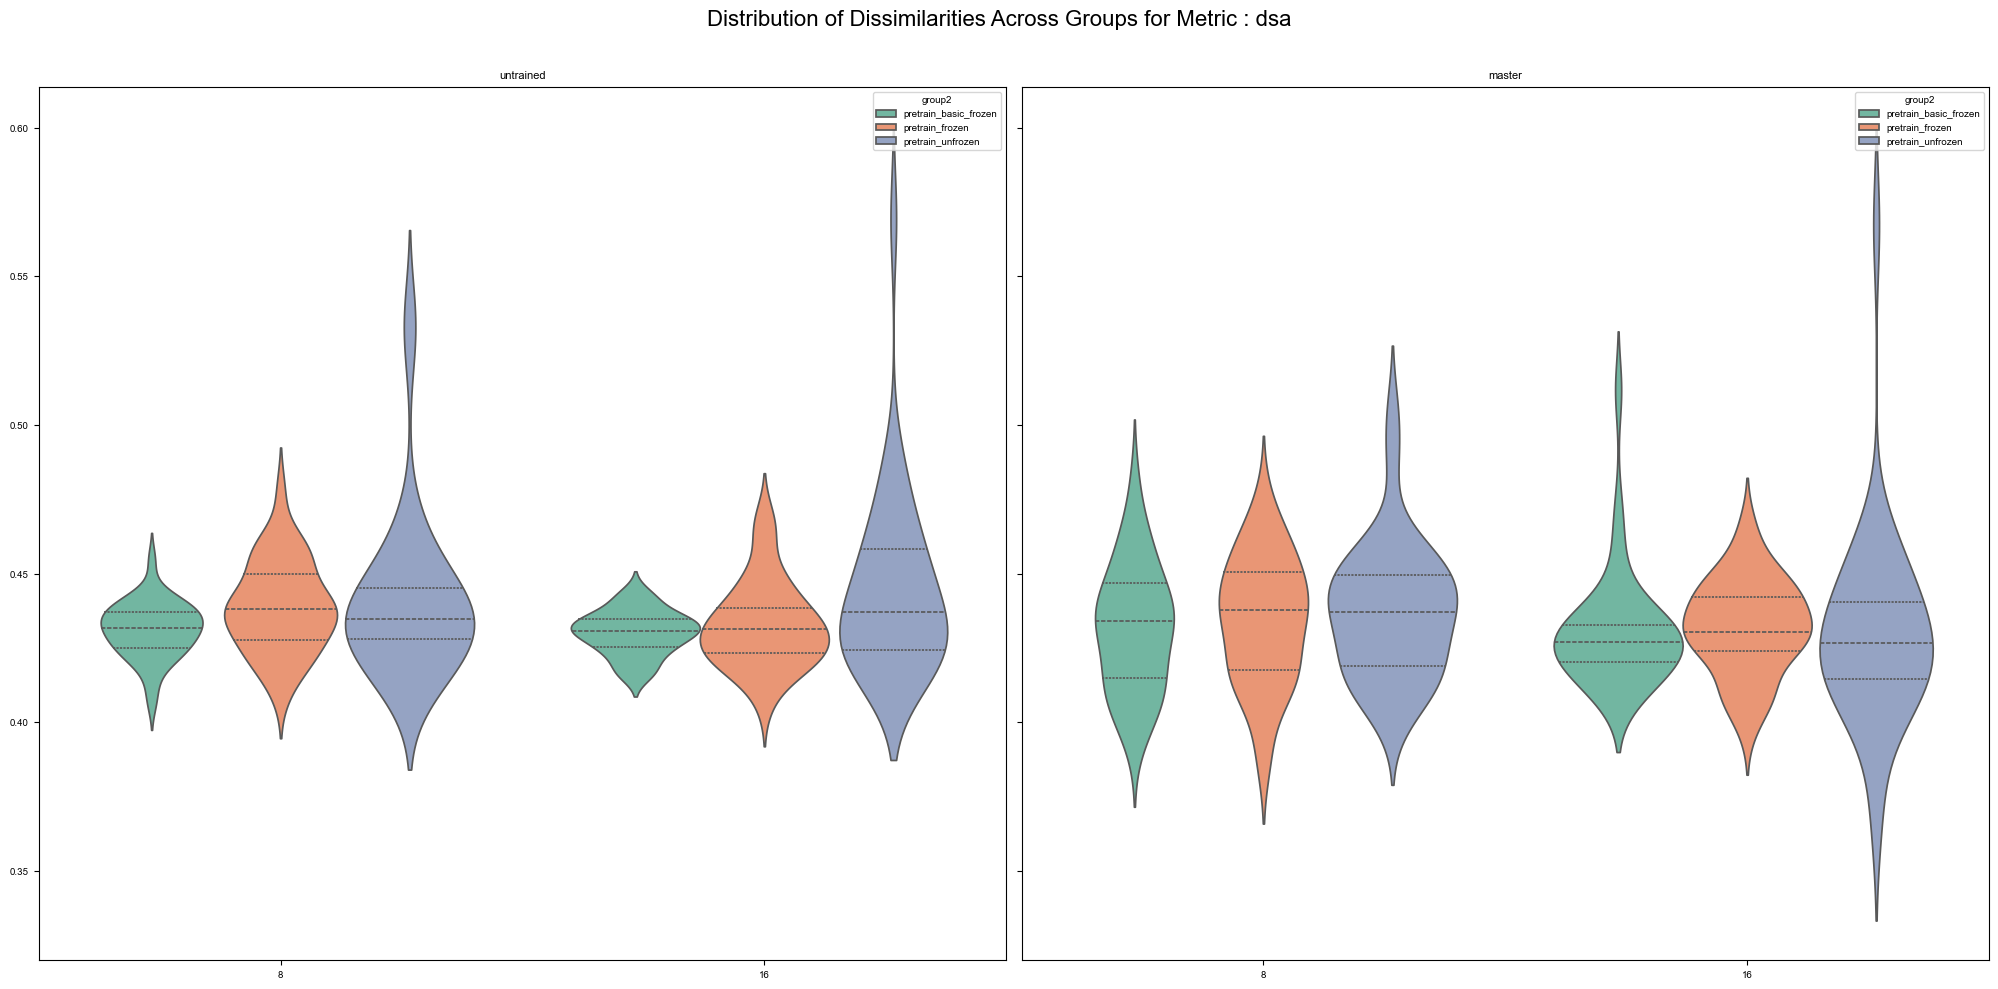

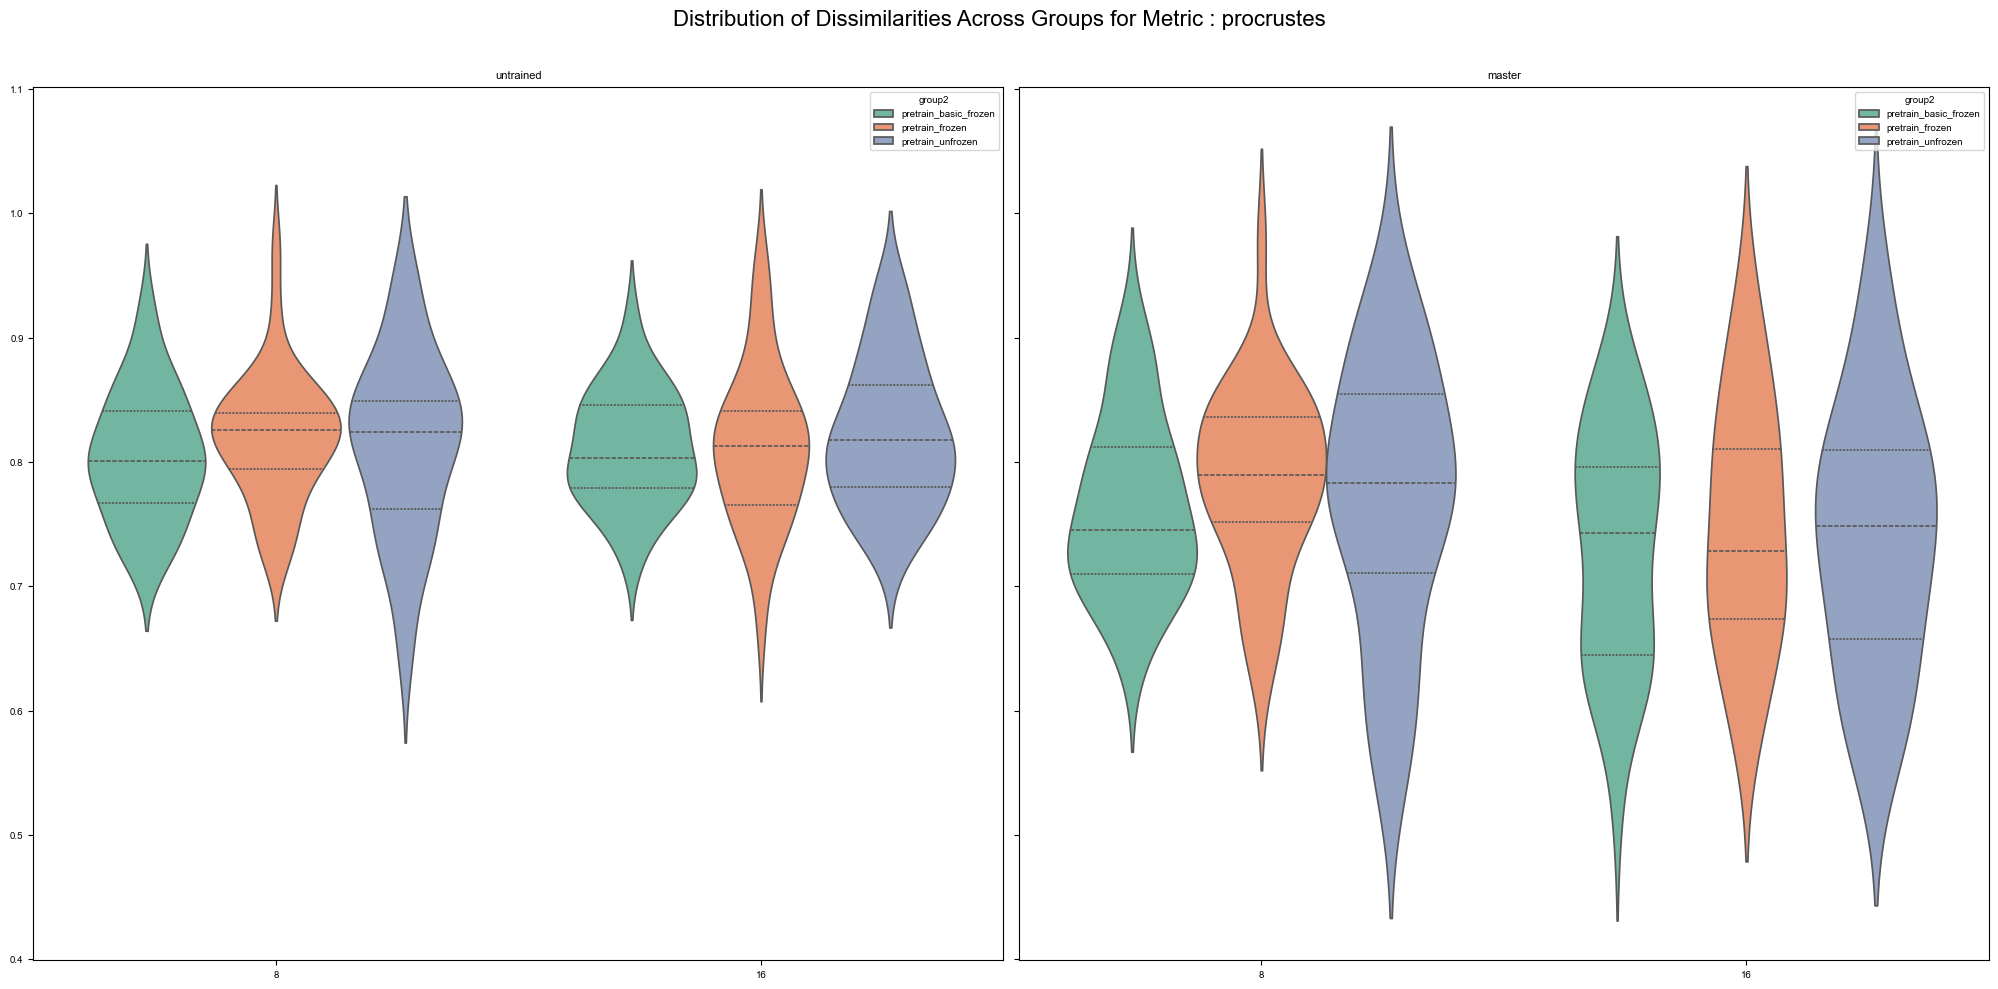

In [59]:
discriminate_df(df_selected, groups_base, criteria="d_model")

In [60]:
groups_trained = [
    "master",
    "pretrain_frozen",
    "pretrain_unfrozen",
]
other_groups = [group for group in df["group1"].unique() if group not in groups_trained]

In [61]:
df[df["group1"] == "master"]

,d_model,n_layers,learning_rate,batch_size,group1,group2,measure,dissimilarity,accuracy_1,accuracy_2
20,8,2,0.010,16,master,untrained,cka,0.959609,1.0,-1.000000
21,8,2,0.010,16,master,master_frozen,cka,0.930409,1.0,0.539886
22,8,2,0.010,16,master,master,cka,0.000153,1.0,1.000000
23,8,2,0.010,16,master,pretrain_basic_frozen,cka,0.959725,1.0,0.982076
24,8,2,0.010,16,master,pretrain_anti_frozen,cka,0.974028,1.0,1.000000
...,...,...,...,...,...,...,...,...,...,...
19125,8,1,0.001,32,master,pretrain_delay_frozen,procrustes,0.764182,1.0,1.000000
19126,8,1,0.001,32,master,pretrain_basic_anti_frozen,procrustes,0.722244,1.0,1.000000
19127,8,1,0.001,32,master,pretrain_basic_delay_frozen,procrustes,0.730170,1.0,0.946842
19128,8,1,0.001,32,master,pretrain_frozen,procrustes,0.742235,1.0,1.000000


In [62]:
df_selected = df[
    # For rows where model1 is in group1
    ((df["group1"].isin(groups_trained)) & (df["accuracy_1"] == 1))
    |
    # For rows where model1 is not in group1 (accuracy_1 can be anything)
    (~df["group1"].isin(groups_trained))
    |
    # For rows where model2 is in group2
    ((df["group2"].isin(groups_trained)) & (df["accuracy_2"] == 1))
    |
    # For rows where model2 is not in group2 (accuracy_2 can be anything)
    (~df["group2"].isin(groups_trained))
]

In [63]:
# Group by 'group1', 'group2', and 'measure', then calculate median dissimilarities
median_dissimilarities = (
    df_selected.groupby(["group1", "group2", "measure"])["dissimilarity"].median().reset_index()
)

# Pivot the data to prepare it for the heatmap
pivot_table = median_dissimilarities.pivot_table(
    index="group1", columns="group2", values="dissimilarity"
)

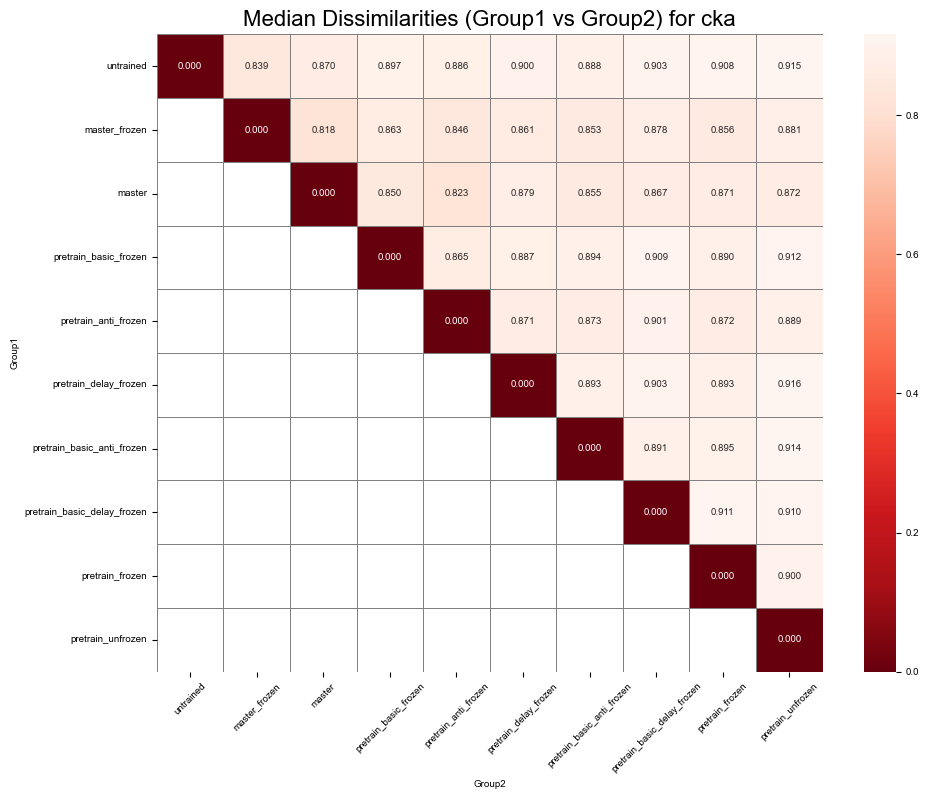

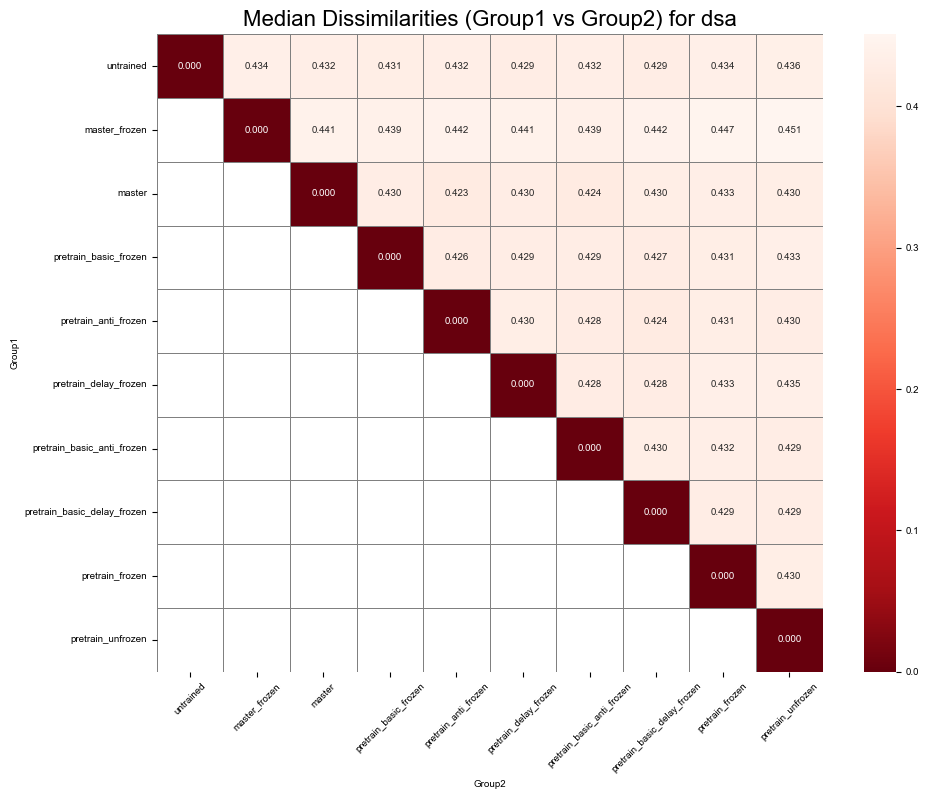

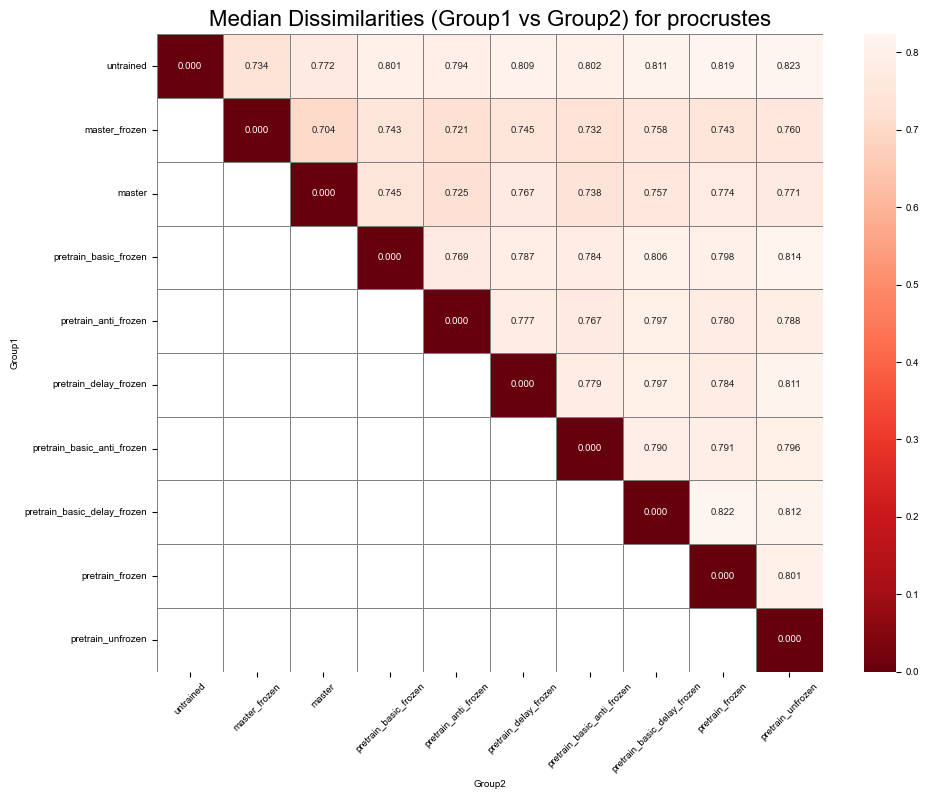

In [64]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming median_dissimilarities DataFrame is defined

# Define the desired order for groups
groups = [
    "untrained",
    "master_frozen",
    "master",
    "pretrain_basic_frozen",
    "pretrain_anti_frozen",
    "pretrain_delay_frozen",
    "pretrain_basic_anti_frozen",
    "pretrain_basic_delay_frozen",
    "pretrain_frozen",
    "pretrain_unfrozen",
]

# Unique measures
measures = df["measure"].unique()

# Plot heatmap for each measure
for measure in measures:
    # Filter the pivot table for the specific measure
    measure_pivot = median_dissimilarities[
        median_dissimilarities["measure"] == measure
    ].pivot(index="group1", columns="group2", values="dissimilarity")

    # Reorder the rows and columns according to the specified groups
    measure_pivot = measure_pivot.reindex(index=groups, columns=groups)

    # Create a mask for the lower triangle (excluding the diagonal)
    mask = np.tril(np.ones_like(measure_pivot, dtype=bool), -1)

    # Create a heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        measure_pivot,
        annot=True,
        fmt=".3f",
        cmap="Reds_r",
        cbar=True,
        linewidths=0.5,
        linecolor="gray",
        mask=mask,  # Apply the mask to show only the upper triangle including the diagonal
    )
    plt.title(f"Median Dissimilarities (Group1 vs Group2) for {measure}", fontsize=16)
    plt.xlabel("Group2")
    plt.ylabel("Group1")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

['untrained' 'master_frozen' 'master' 'pretrain_partial' 'pretrain_frozen'
 'pretrain_unfrozen']


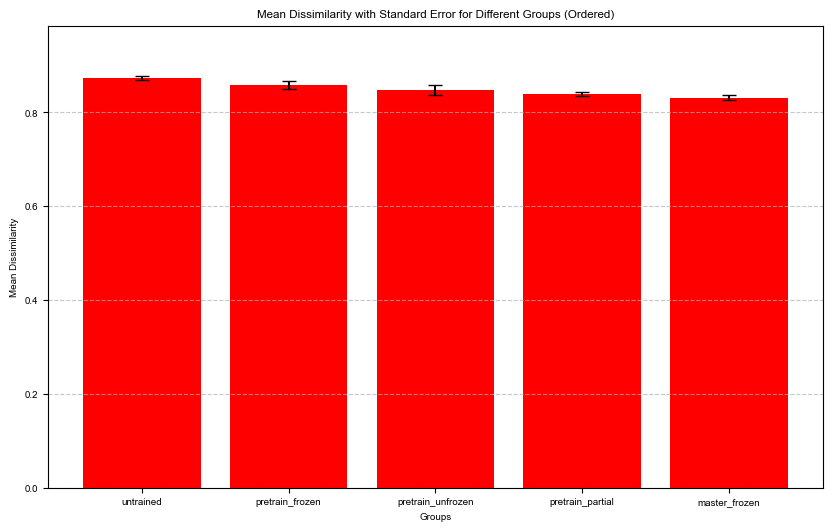

['untrained' 'master_frozen' 'master' 'pretrain_partial' 'pretrain_frozen'
 'pretrain_unfrozen']


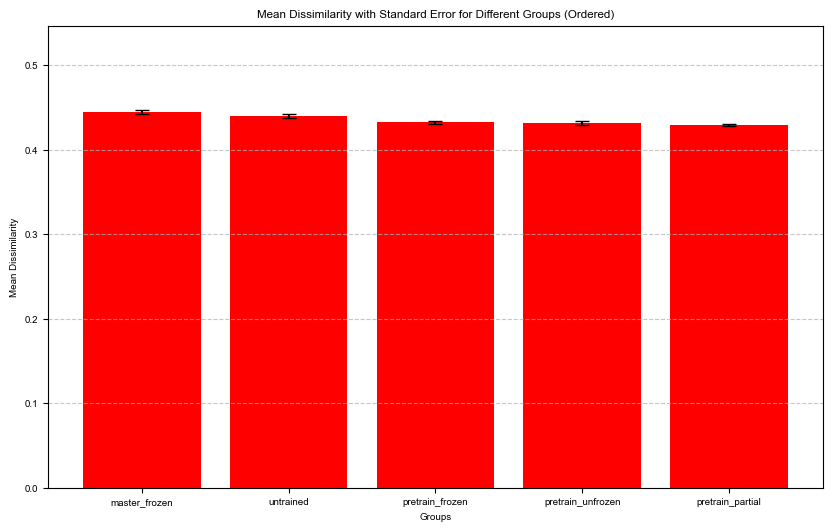

['untrained' 'master_frozen' 'master' 'pretrain_partial' 'pretrain_frozen'
 'pretrain_unfrozen']


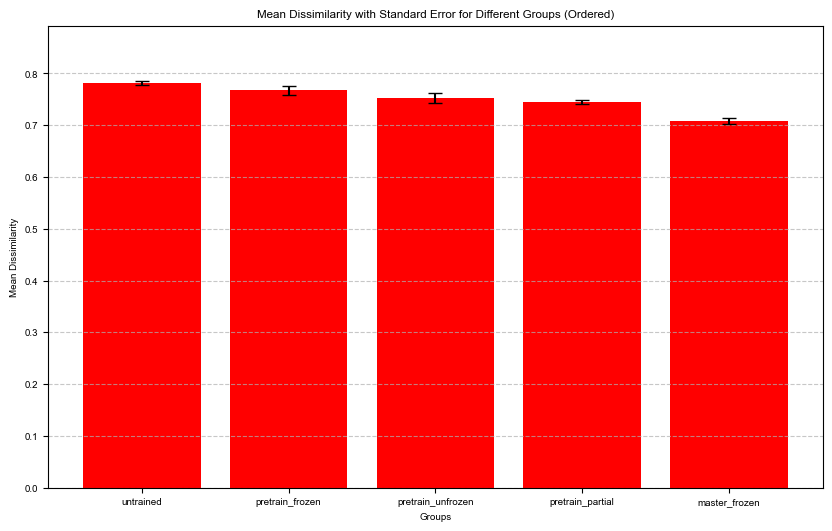

In [65]:
from numpy import mean


for measure in measures:
    # Create a bar chart with error bars
    df_standard = t_standart_error_dissimilarity_all_groups(df_selected, measure)
    groups, mean_dissimilarities, standard_errors = (
        df_standard["group"],
        df_standard["mean_dissimilarities"],
        df_standard["standard_errors"],
    )
    # Step 1: Zip the data together and sort by mean_dissimilarities in descending order
    sorted_data = sorted(
        zip(mean_dissimilarities, standard_errors, groups), reverse=True
    )

    # Step 2: Unzip the sorted data back into separate lists
    mean_dissimilarities, standard_errors, groups = zip(*sorted_data)

    # Step 3: Create the bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(groups, mean_dissimilarities, yerr=standard_errors, capsize=5, color="red")
    plt.xlabel("Groups")
    plt.ylabel("Mean Dissimilarity")
    plt.title("Mean Dissimilarity with Standard Error for Different Groups (Ordered)")
    plt.ylim(
        0, max(mean_dissimilarities) + max(standard_errors) + 0.1
    )  # Adjust the y-axis limit if needed
    plt.grid(True, axis="y", linestyle="--", alpha=0.7)

    # Display the plot
    plt.show()

In [66]:
df_test = t_test_all_pairs(df_selected, "dsa")

['untrained' 'master_frozen' 'master' 'pretrain_partial' 'pretrain_frozen'
 'pretrain_unfrozen']


In [67]:
group_pairs = find_group_pairs(config, taskset)
dissimilarities_per_shared_task = dissimilarities_per_percentage_of_shared_task(
    group_pairs, df_selected
)

/var/folders/rg/xgkyjs4945d6ckms1nn6v0jm0000gn/T/ipykernel_3827/1154086680.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="comparison", y="adjusted_p_value", data=bar_data, palette="Reds")


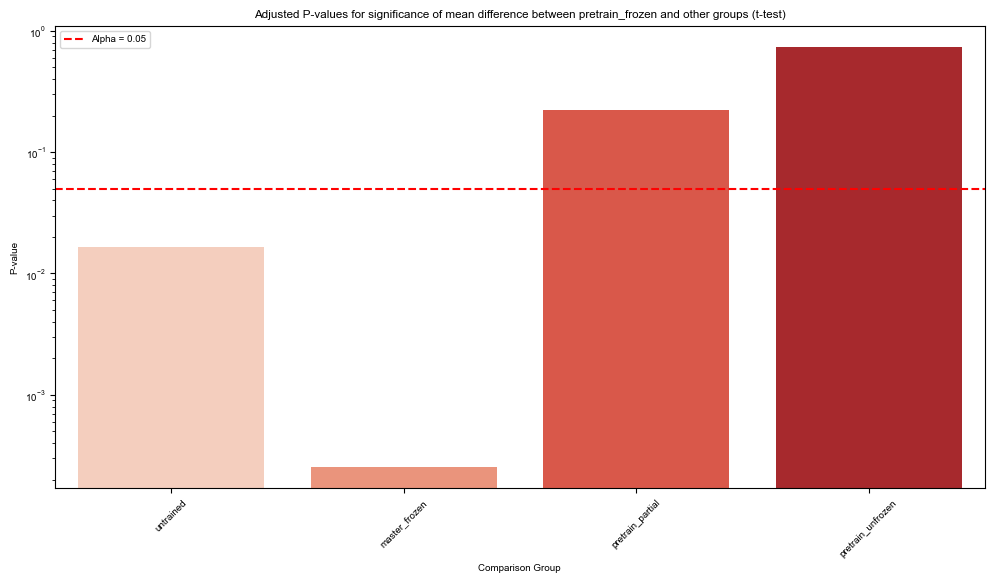

In [68]:
# Extract relevant comparisons where pretrain_frozen is involved
pretrain_frozen_comparisons = df_test[
    df_test["pairs"].apply(lambda x: "pretrain_frozen" in x)
]

# Create a dataframe for the bar plots
bar_data = pretrain_frozen_comparisons.copy()
bar_data["comparison"] = bar_data["pairs"].apply(
    lambda x: x[0] if x[1] == "pretrain_frozen" else x[1]
)

# Bar plot for p-values where pretrain_frozen is one of the groups
plt.figure(figsize=(12, 6))
ax = sns.barplot(x="comparison", y="adjusted_p_value", data=bar_data, palette="Reds")
plt.yscale("log")  # Use log scale for better visibility of p-values
plt.axhline(y=0.05, color="red", linestyle="--", label="Alpha = 0.05")
plt.title(
    "Adjusted P-values for significance of mean difference between pretrain_frozen and other groups (t-test)"
)
plt.xlabel("Comparison Group")
plt.ylabel("P-value")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [69]:
group_pairs = find_group_pairs(config, taskset)
dissimilarities_per_shared_task = dissimilarities_per_percentage_of_shared_task(
    group_pairs, df_selected
)

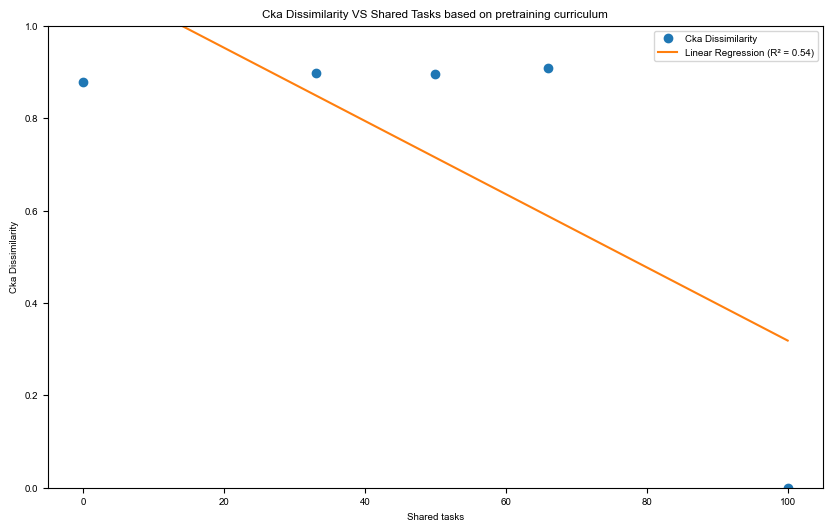

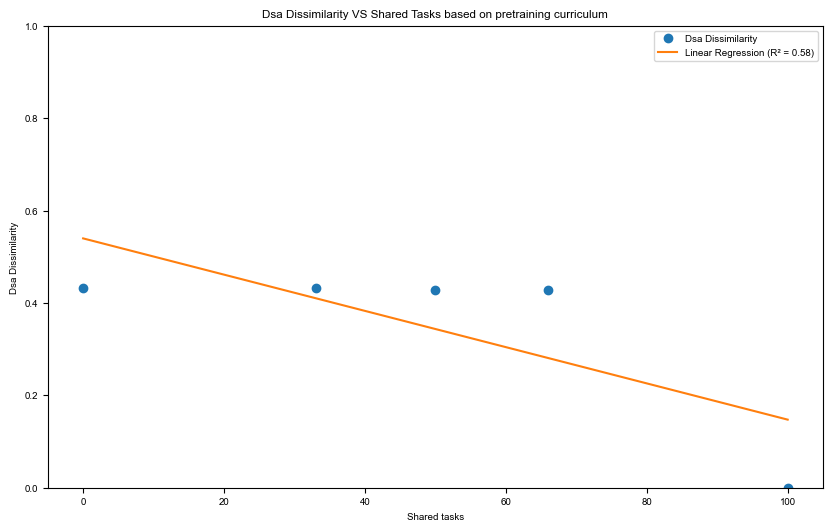

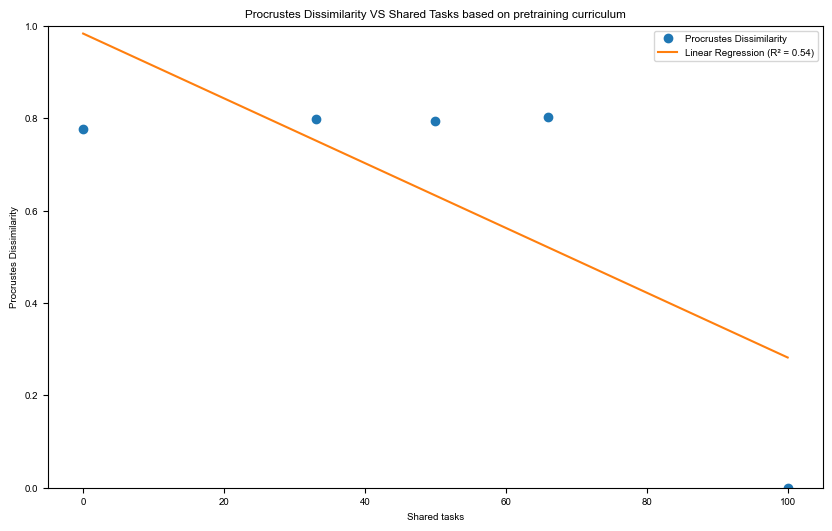

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

for measure in measures:
    dissimilarities_per_shared_task[measure] = {
        k: np.median(v) for k, v in dissimilarities_per_shared_task[measure].items()
    }
    percent_shared_tasks_sorted = sorted(
        list(dissimilarities_per_shared_task[measure].keys())
    )
    dissimilarities = [
        dissimilarities_per_shared_task[measure][percent]
        for percent in percent_shared_tasks_sorted
    ]

    # Convert to numpy arrays for linear regression
    X = np.array(percent_shared_tasks_sorted).reshape(-1, 1)
    y = np.array(dissimilarities)

    # Perform linear regression
    model = LinearRegression()
    model.fit(X, y)
    predictions = model.predict(X)

    # Calculate R²
    r2 = r2_score(y, predictions)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(
        percent_shared_tasks_sorted,
        dissimilarities,
        "o",  # Plot original data points
        label=f"{measure.capitalize()} Dissimilarity",
    )
    plt.plot(
        percent_shared_tasks_sorted,
        predictions,
        "-",  # Plot linear regression line
        label=f"Linear Regression (R² = {r2:.2f})",
    )
    plt.xlabel("Shared tasks")
    plt.ylim(0, 1)
    plt.ylabel(f"{measure.capitalize()} Dissimilarity")
    plt.title(
        f"{measure.capitalize()} Dissimilarity VS Shared Tasks based on pretraining curriculum"
    )
    plt.legend()
    plt.show()

#### Learning dynamics

For now, only analysis for pretrain_frozen against pretrain_unfrozen

In [71]:
dissimilarities_groups, groups_training = get_dissimilarities_groups(taskset)

/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/repal-8PB6Q6y1-py3.11/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


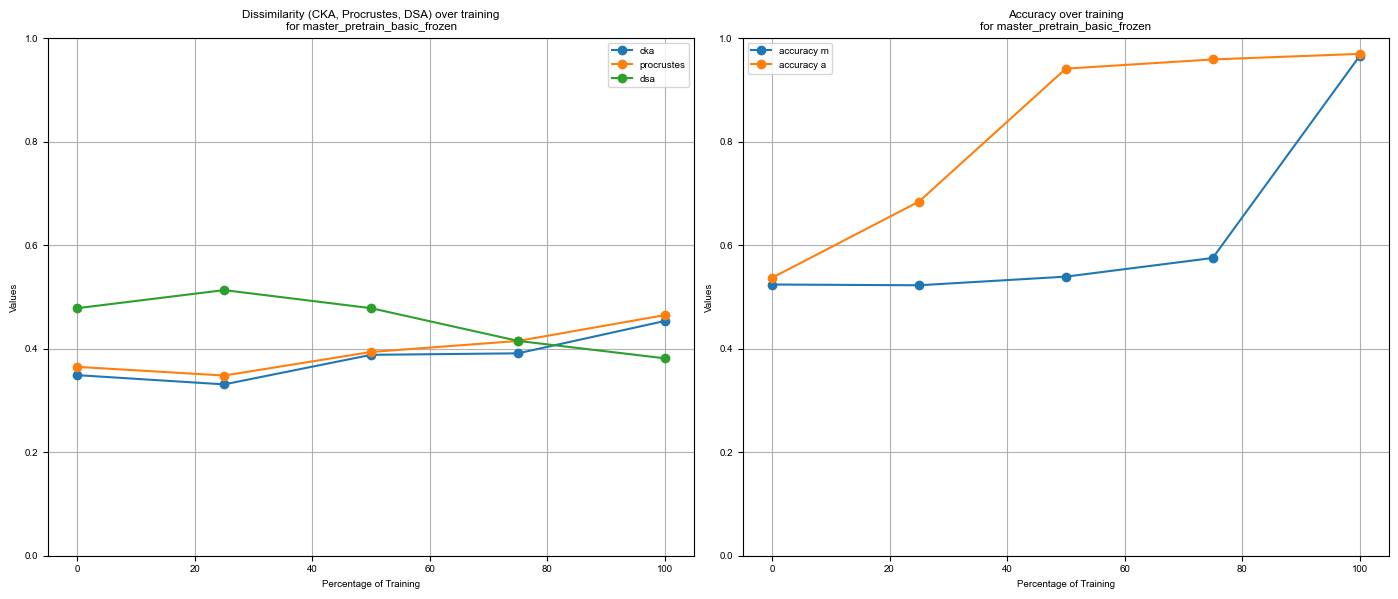

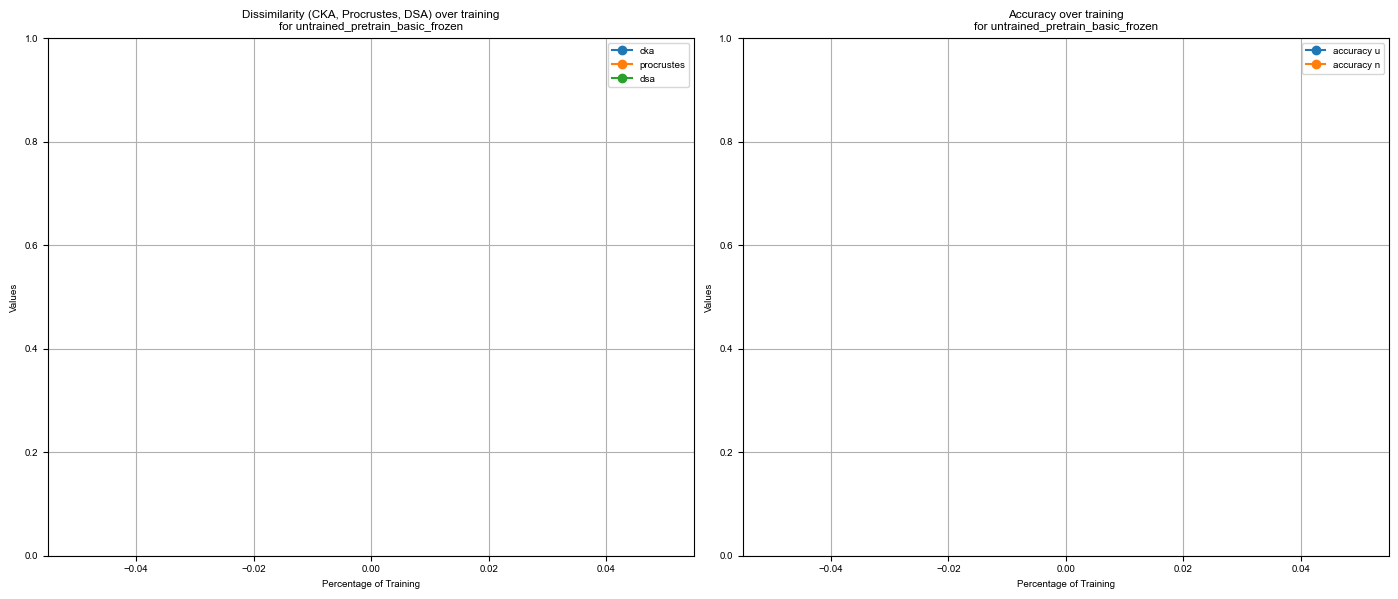

KeyboardInterrupt: 

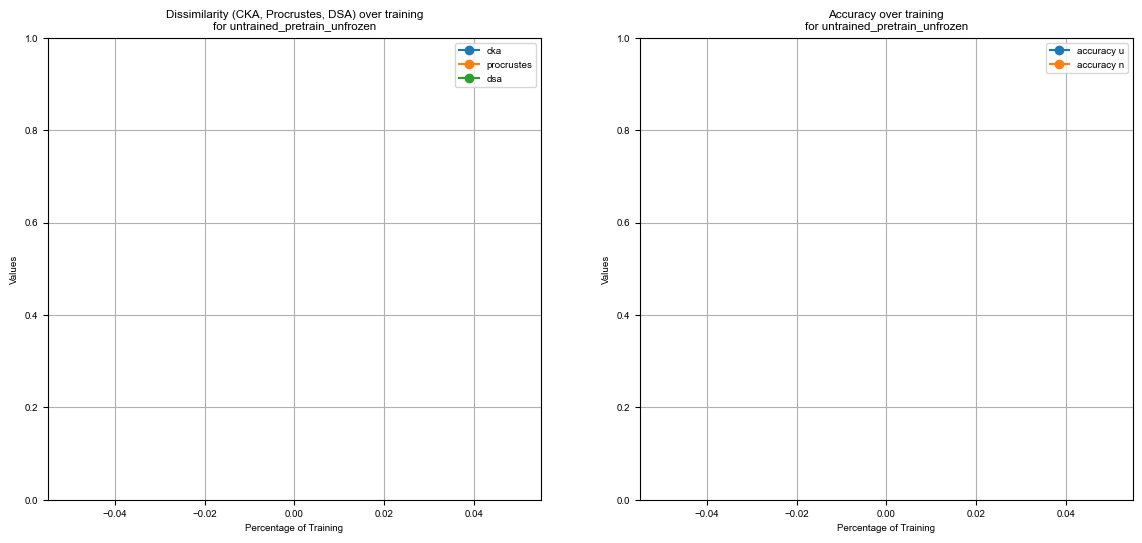

In [72]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Assuming dissimilarities_groups is defined from your previous code

# Iterate over each group in groups_training
for group_training in groups_training:
    if "master_frozen" not in group_training:
        dissimilarities_interpolated = dissimilarities_groups[group_training]

        # X-axis values
        x_values = [0, 25, 50, 75, 100]

        # Measures for the two plots
        measures_plot1 = ["cka", "procrustes", "dsa"]
        measures_plot2 = ["accuracy_1", "accuracy_2"]

        # Create the figure and the two subplots
        fig, axs = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns

        # Plot for the first set of measures
        for key in measures_plot1:
            values = dissimilarities_interpolated[key]
            axs[0].plot(x_values, list(values.values()), marker="o", label=key)

        axs[0].set_xlabel("Percentage of Training")
        axs[0].set_ylabel("Values")
        axs[0].set_title(
            "Dissimilarity (CKA, Procrustes, DSA) over training\nfor {}".format(
                group_training
            )
        )
        axs[0].set_ylim(0, 1)
        axs[0].legend()
        axs[0].grid(True)

        # Plot for the second set of measures
        for i, key in enumerate(measures_plot2):
            values = dissimilarities_interpolated[key]
            # Rename legend label for accuracy
            label = f"accuracy {group_training[i]}"
            axs[1].plot(x_values, list(values.values()), marker="o", label=label)

        axs[1].set_xlabel("Percentage of Training")
        axs[1].set_ylabel("Values")
        axs[1].set_title("Accuracy over training\nfor {}".format(group_training))
        axs[1].set_ylim(0, 1)
        axs[1].legend()
        axs[1].grid(True)

        # Adjust layout to avoid overlapping elements
        plt.tight_layout()

        # Display the plots
        plt.show()

In [ ]:
dissimilarities_groups, groups_training = get_dissimilarities_groups(taskset)

In [ ]:
groups_training

['master_frozen_pretrain_frozen',
 'master_pretrain_basic_frozen',
 'master_frozen_master',
 'untrained_pretrain_basic_frozen',
 'master_frozen_pretrain_anti_frozen',
 'untrained_pretrain_unfrozen',
 'master_frozen_untrained',
 'pretrain_frozen_master',
 'master_master',
 'master_pretrain_delay_frozen',
 'untrained_pretrain_frozen',
 'pretrain_basic_delay_frozen_master',
 'untrained_pretrain_delay_frozen',
 'untrained_master_frozen',
 'master_frozen_pretrain_basic_frozen',
 'pretrain_unfrozen_pretrain_unfrozen',
 'untrained_pretrain_anti_frozen',
 'untrained_untrained',
 'untrained_pretrain_basic_delay_frozen',
 'master_frozen_pretrain_basic_delay_frozen',
 'master_frozen_master_frozen',
 'master_frozen_pretrain_unfrozen',
 'pretrain_unfrozen_master',
 'master_frozen_pretrain_basic_anti_frozen',
 'master_frozen_pretrain_delay_frozen',
 'untrained_pretrain_basic_anti_frozen',
 'master_pretrain_anti_frozen',
 'untrained_master',
 'master_pretrain_basic_anti_frozen']

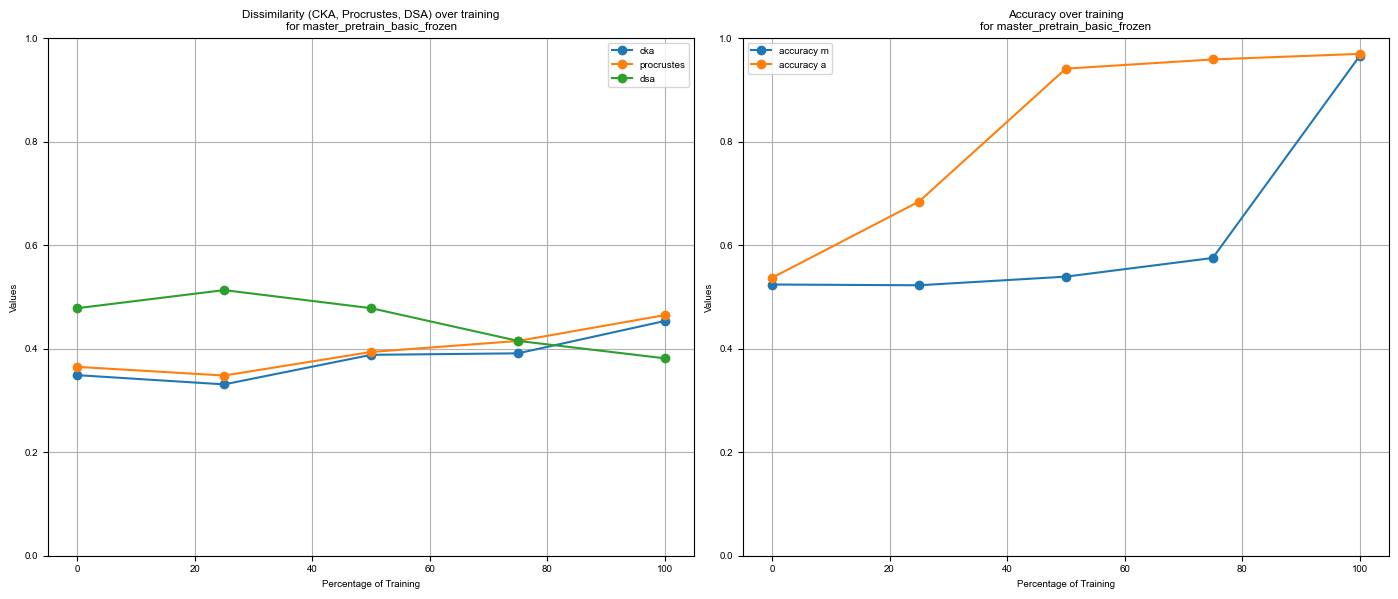

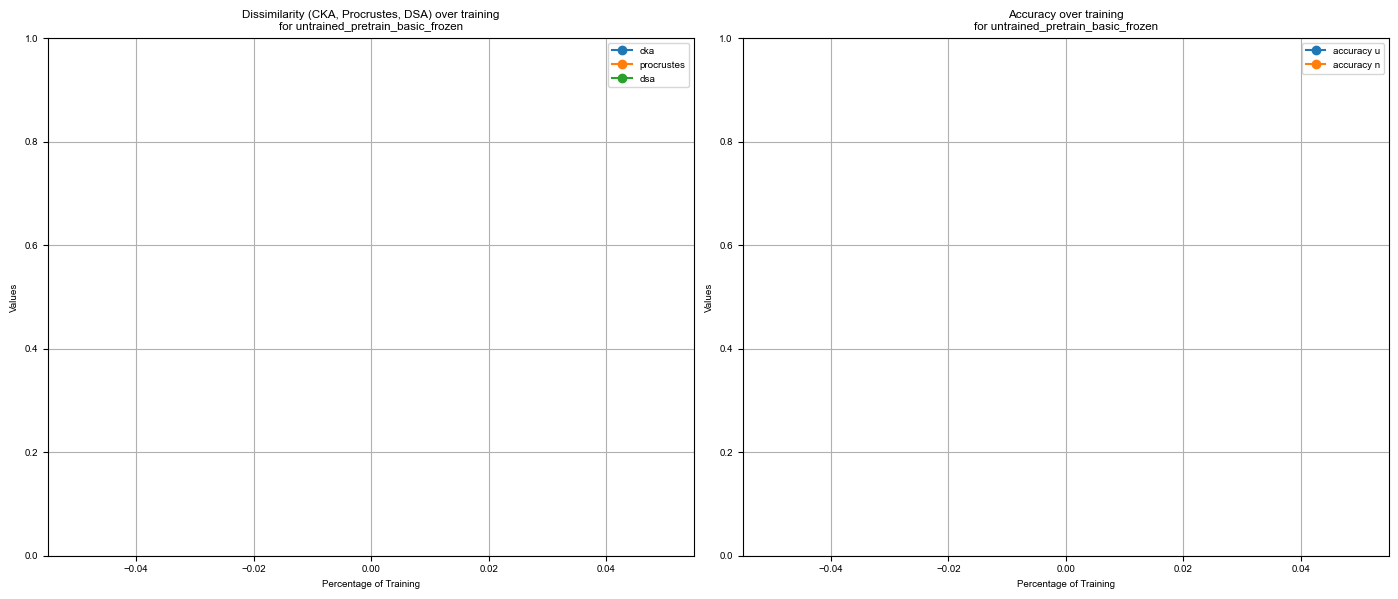

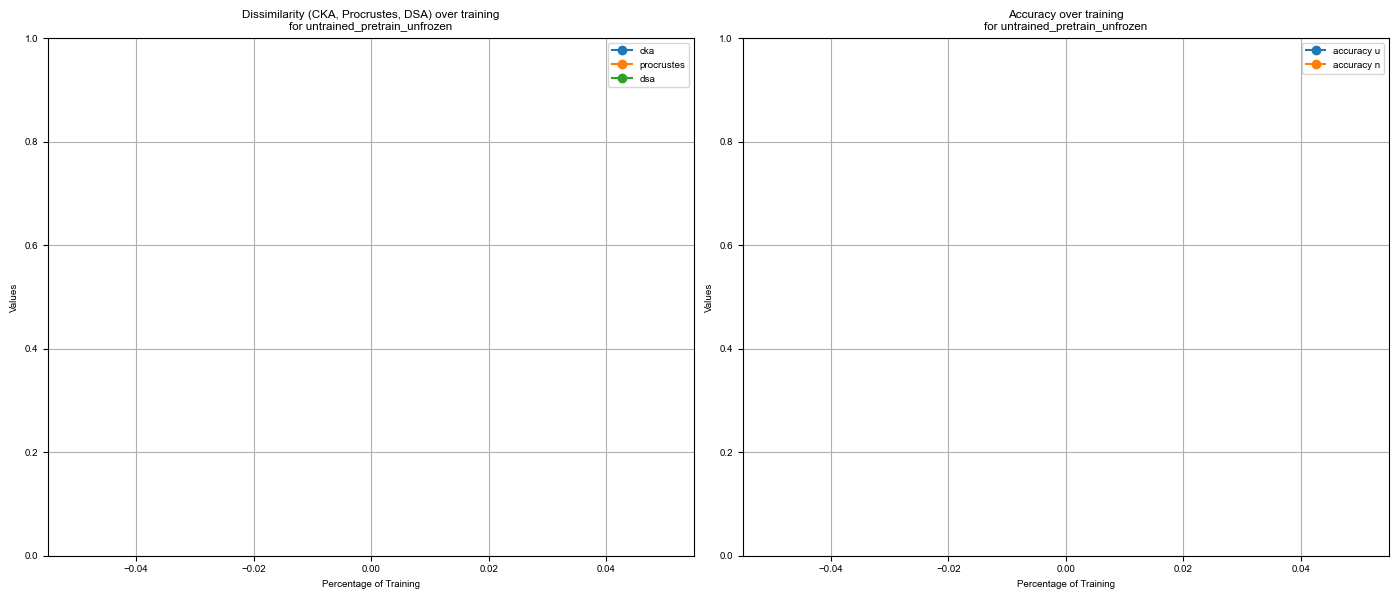

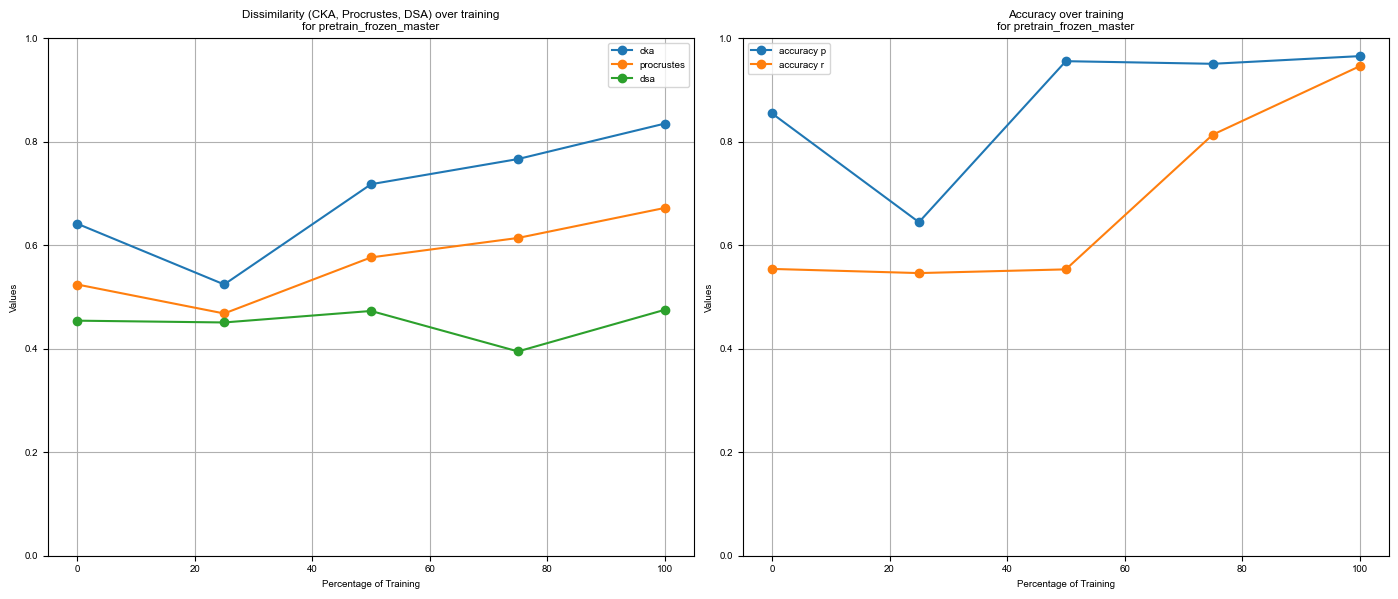

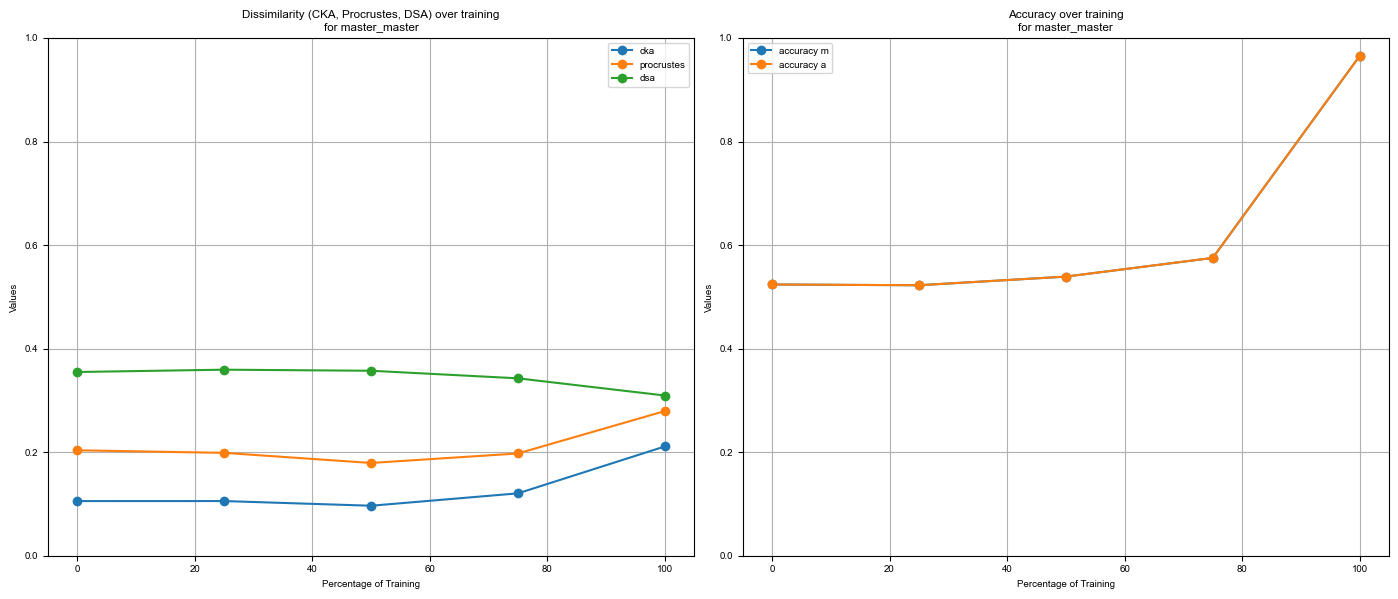

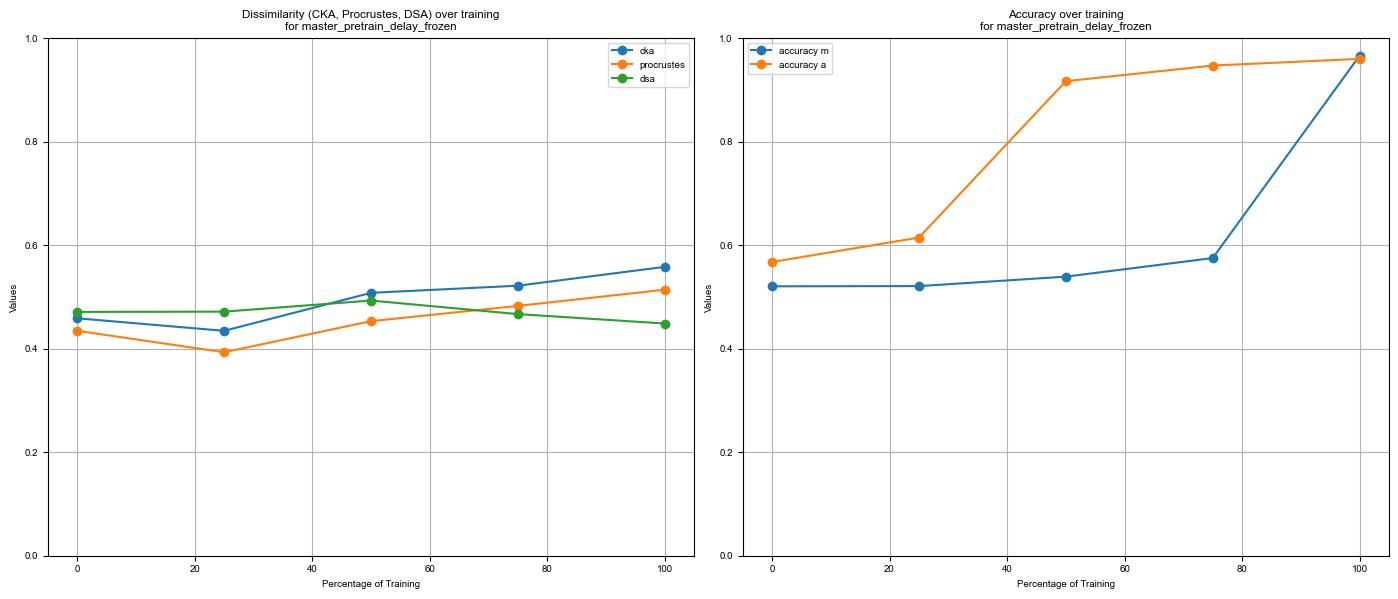

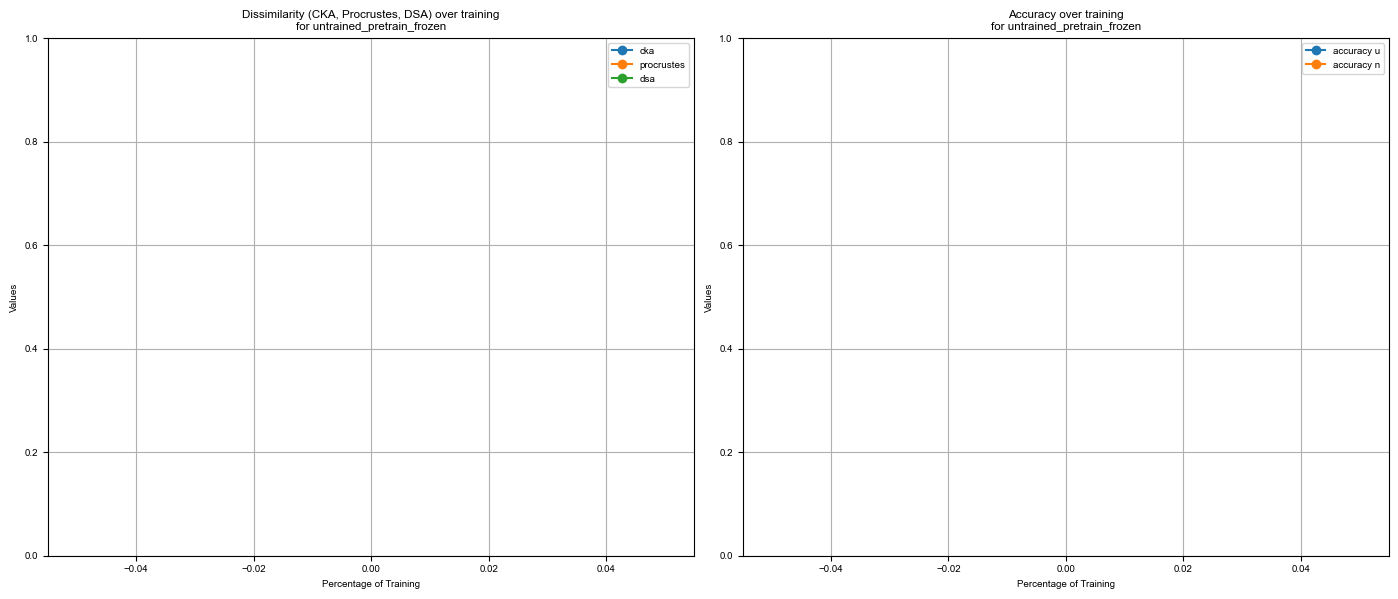

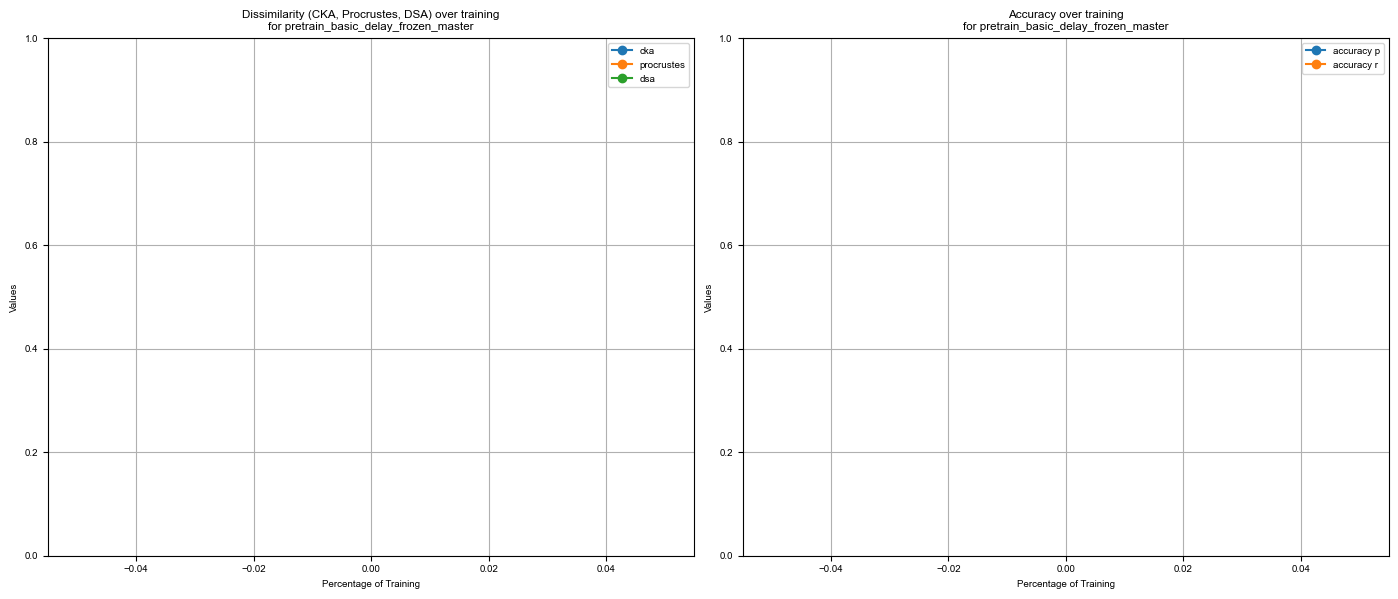

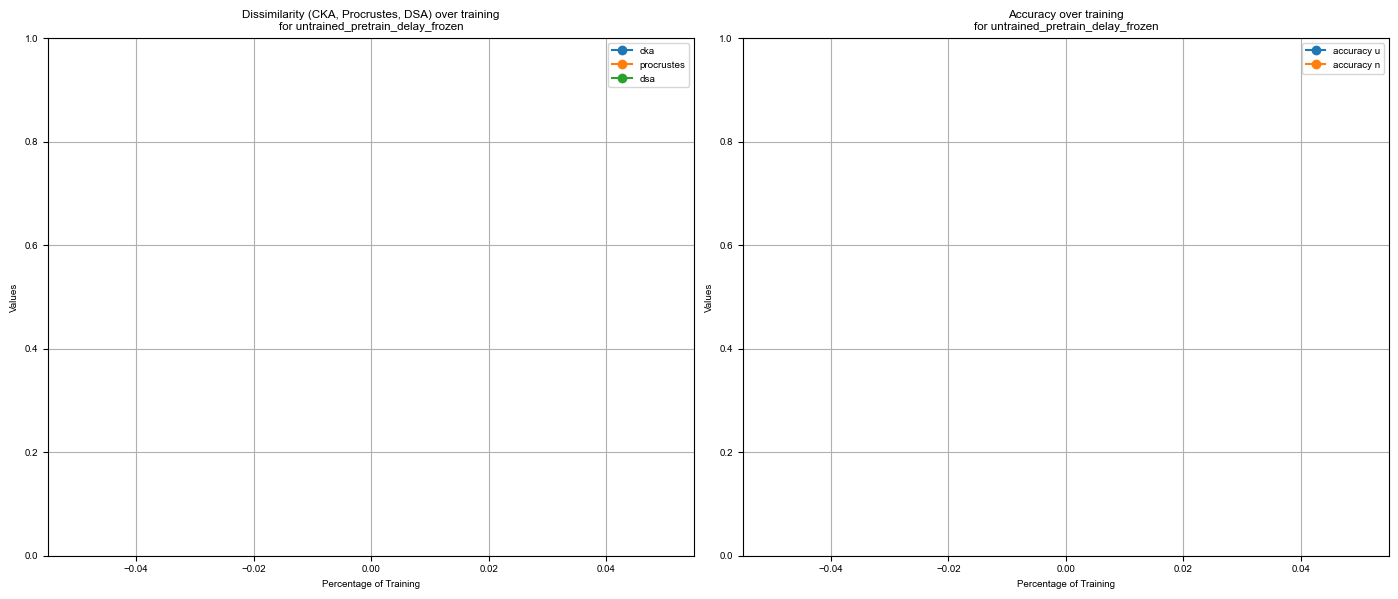

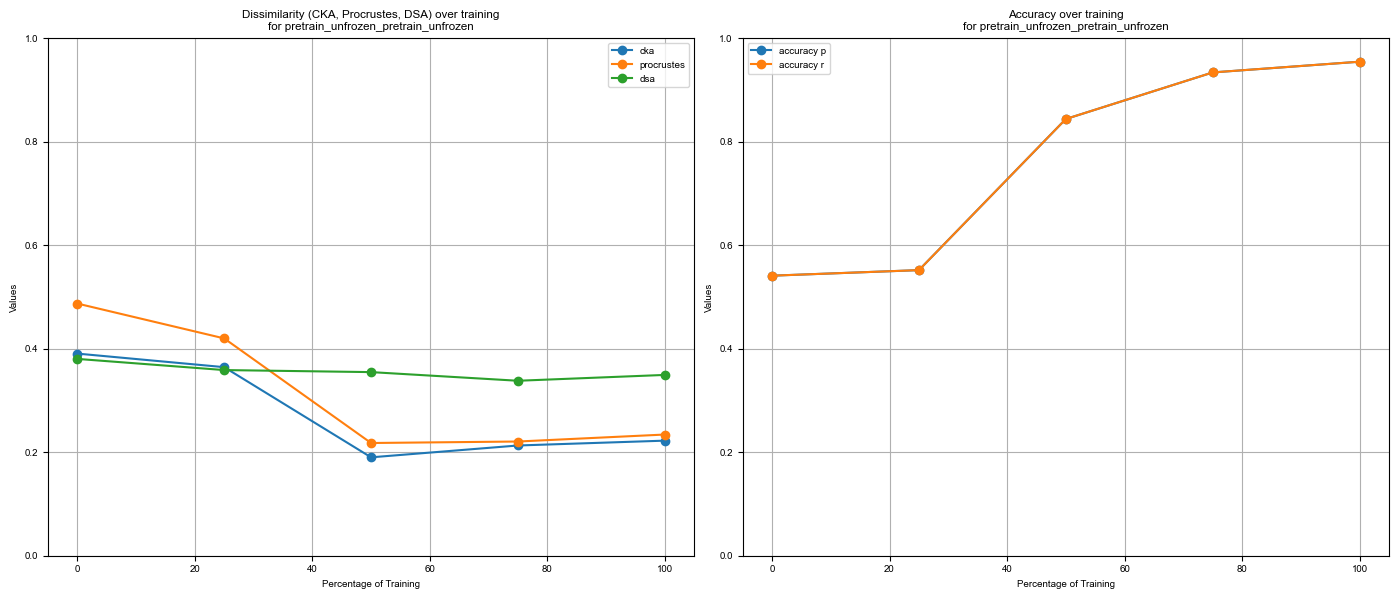

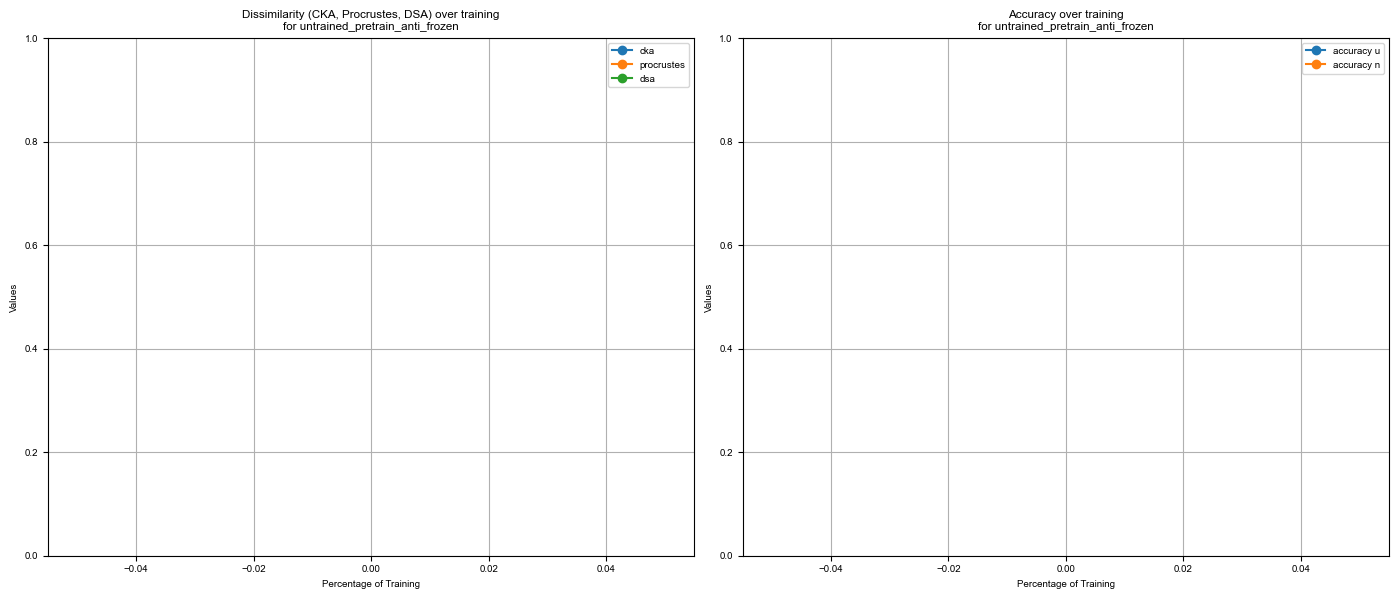

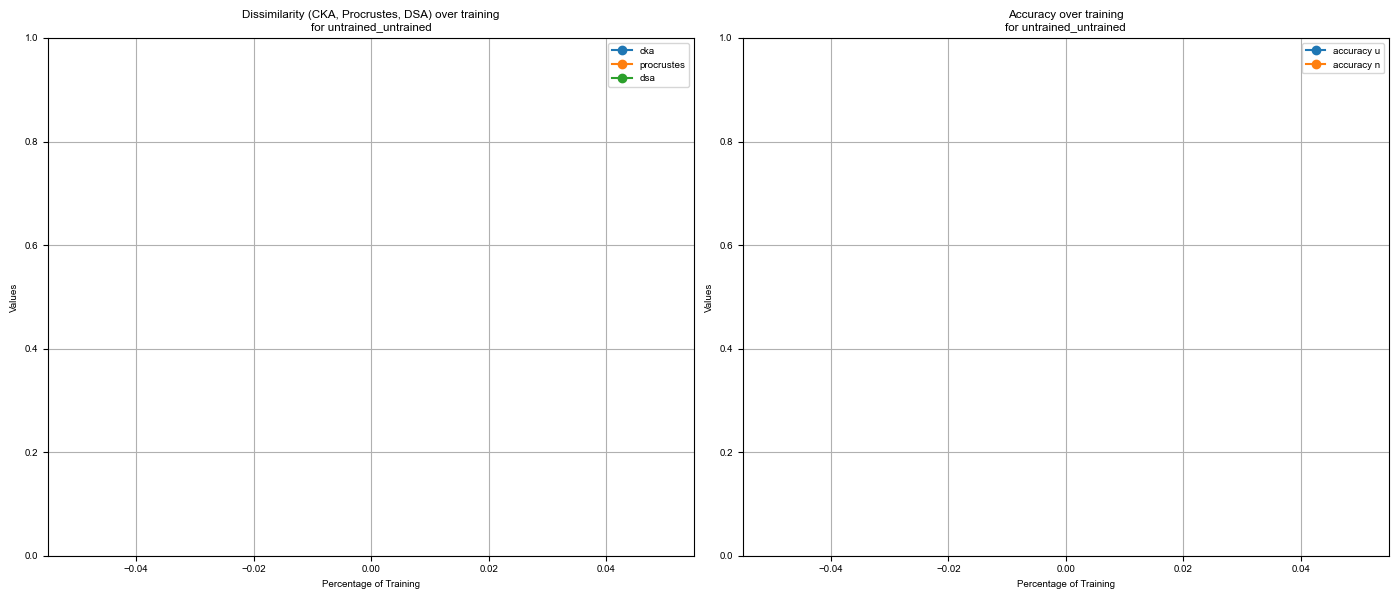

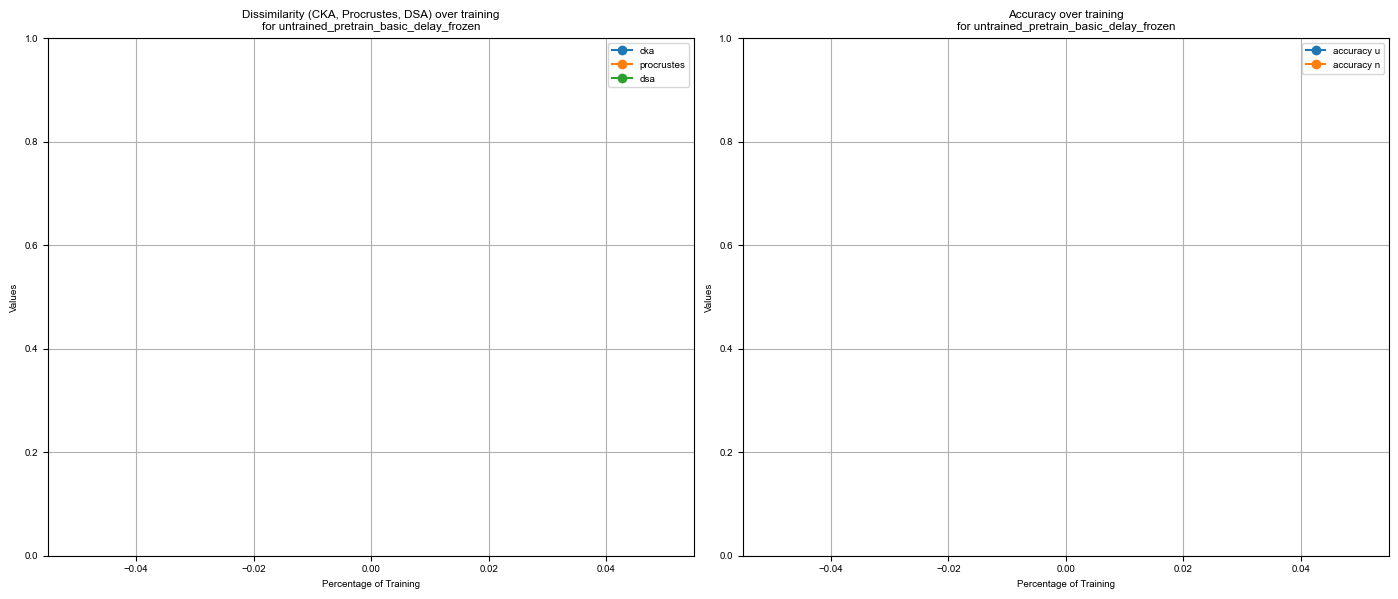

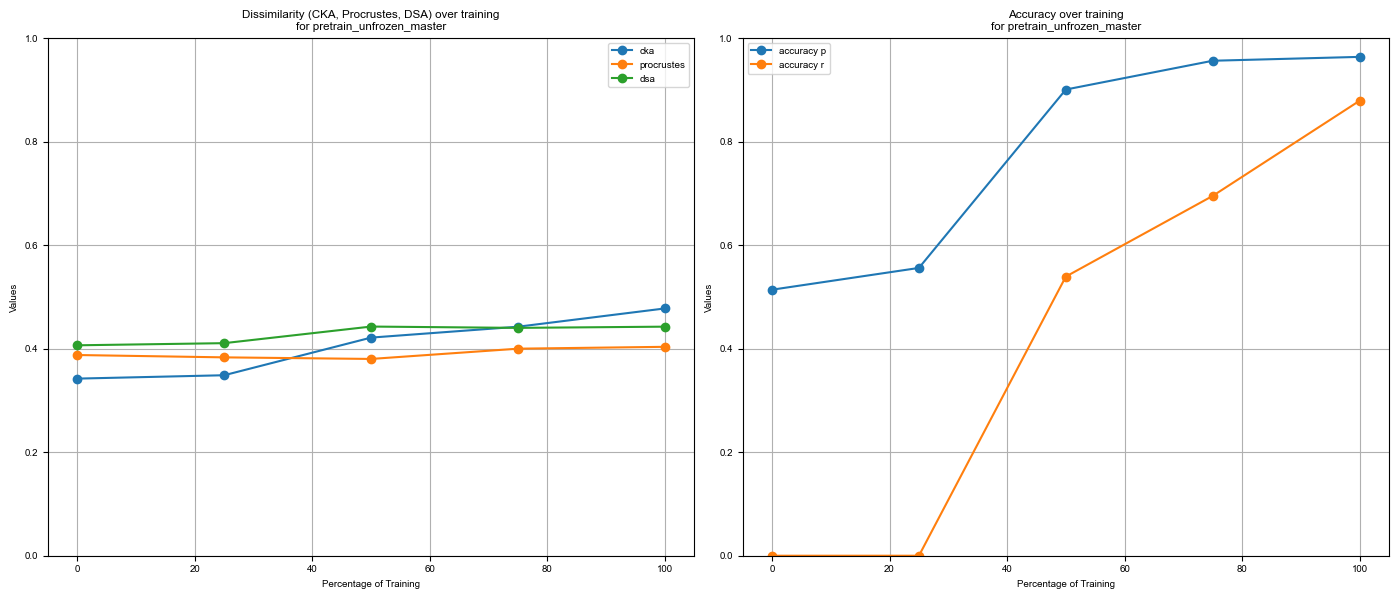

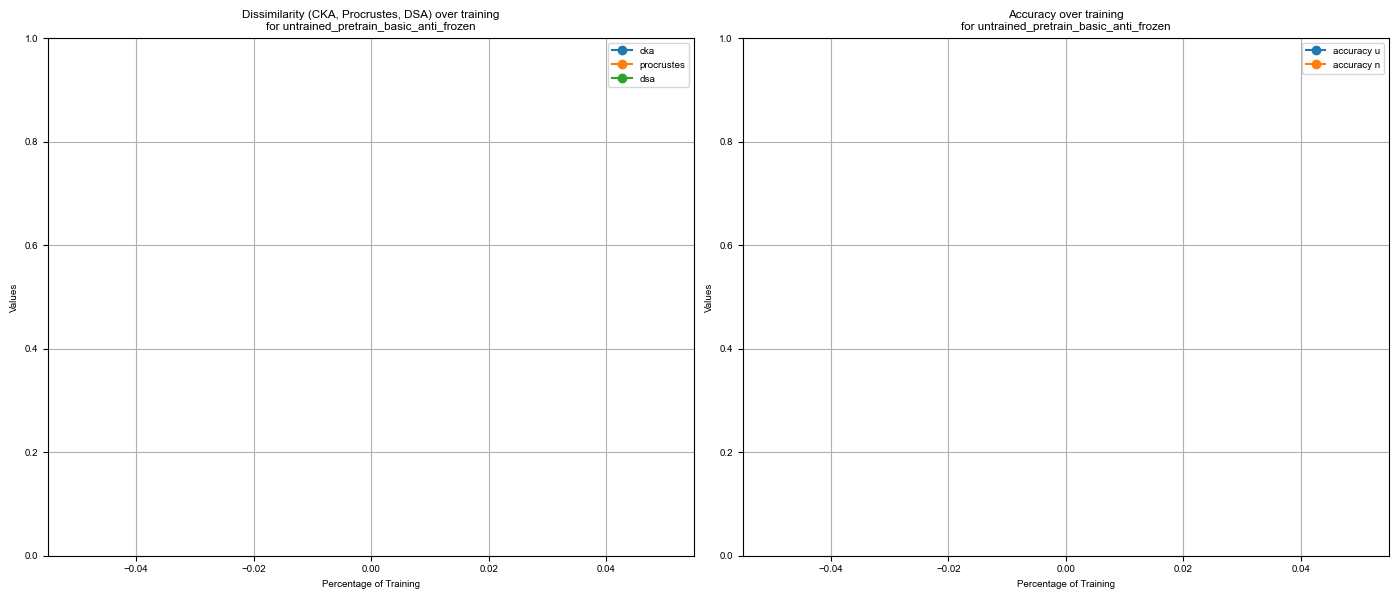

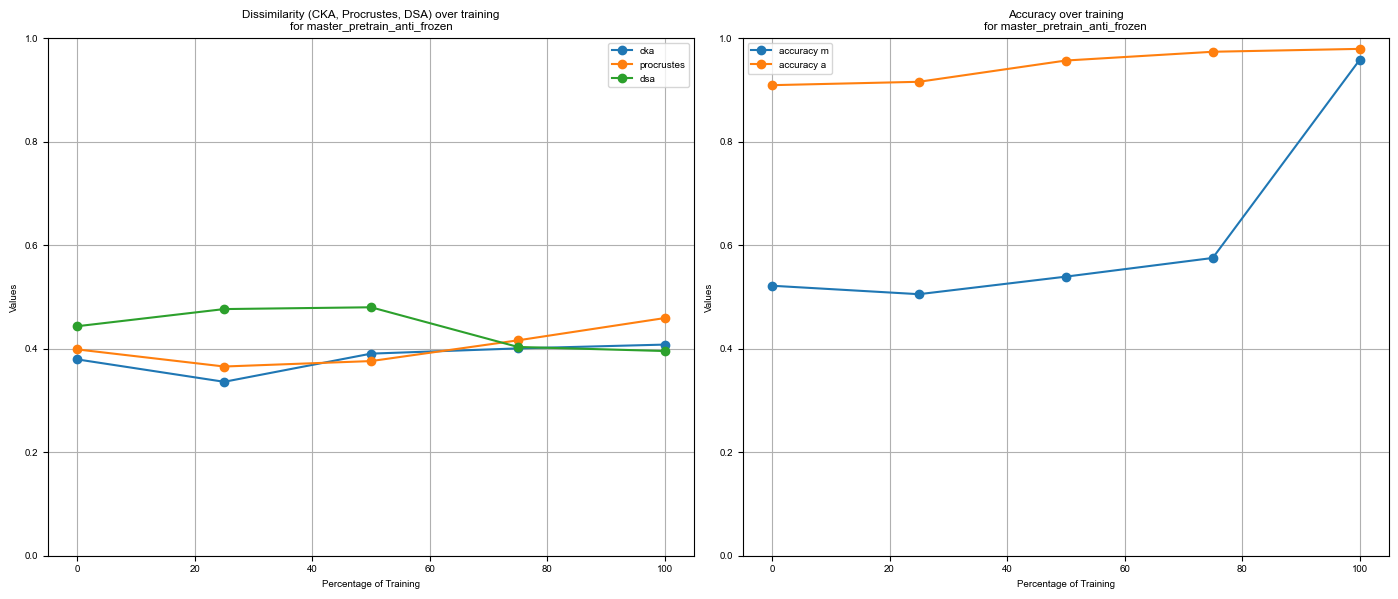

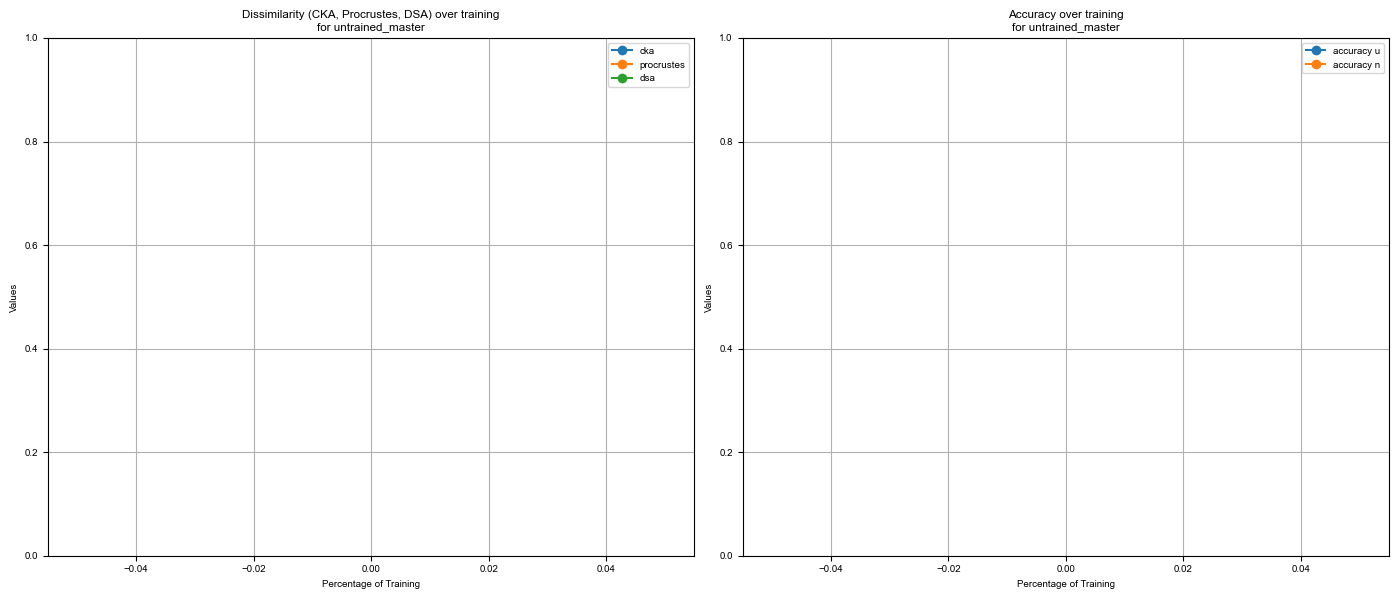

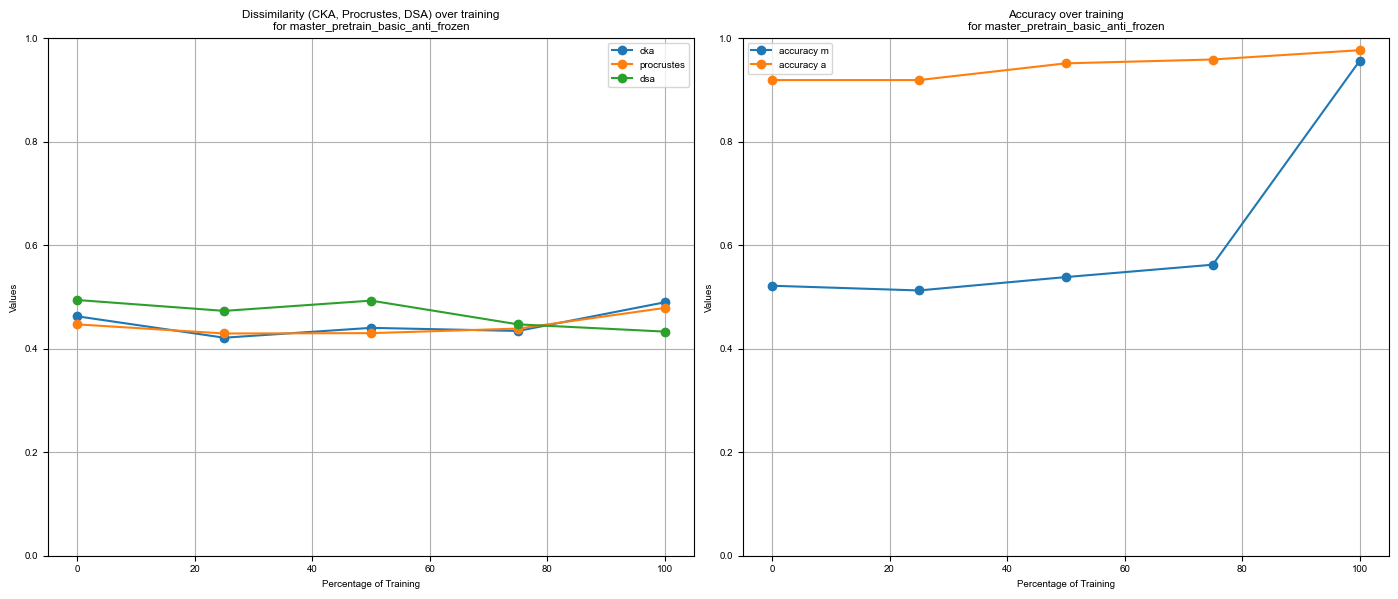

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Assuming dissimilarities_groups is defined from your previous code

# Iterate over each group in groups_training
for group_training in groups_training:
    if "master_frozen" not in group_training:
        dissimilarities_interpolated = dissimilarities_groups[group_training]

        # X-axis values
        x_values = [0, 25, 50, 75, 100]

        # Measures for the two plots
        measures_plot1 = ["cka", "procrustes", "dsa"]
        measures_plot2 = ["accuracy_1", "accuracy_2"]

        # Create the figure and the two subplots
        fig, axs = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns

        # Plot for the first set of measures
        for key in measures_plot1:
            values = dissimilarities_interpolated[key]
            axs[0].plot(x_values, list(values.values()), marker="o", label=key)

        axs[0].set_xlabel("Percentage of Training")
        axs[0].set_ylabel("Values")
        axs[0].set_title(
            "Dissimilarity (CKA, Procrustes, DSA) over training\nfor {}".format(
                group_training
            )
        )
        axs[0].set_ylim(0, 1)
        axs[0].legend()
        axs[0].grid(True)

        # Plot for the second set of measures
        for i, key in enumerate(measures_plot2):
            values = dissimilarities_interpolated[key]
            # Rename legend label for accuracy
            label = f"accuracy {group_training[i]}"
            axs[1].plot(x_values, list(values.values()), marker="o", label=label)

        axs[1].set_xlabel("Percentage of Training")
        axs[1].set_ylabel("Values")
        axs[1].set_title("Accuracy over training\nfor {}".format(group_training))
        axs[1].set_ylim(0, 1)
        axs[1].legend()
        axs[1].grid(True)

        # Adjust layout to avoid overlapping elements
        plt.tight_layout()

        # Display the plots
        plt.show()

In [ ]:
group_pairs_master = find_group_pairs_master(config, taskset)
diss_cc = get_dissimilarities_shared_task_shared_curriculum(
    group_pairs_master, dissimilarities_groups, x_values
)

In [ ]:
group_pairs_master

{100.0: [('master', 'pretrain_frozen')],
 33.333333333333336: [('master', 'pretrain_basic_frozen'),
  ('master', 'pretrain_anti_frozen'),
  ('master', 'pretrain_delay_frozen')],
 66.66666666666667: [('master', 'pretrain_basic_anti_frozen'),
  ('master', 'pretrain_basic_delay_frozen')],
 0: [('master', 'master_frozen')]}

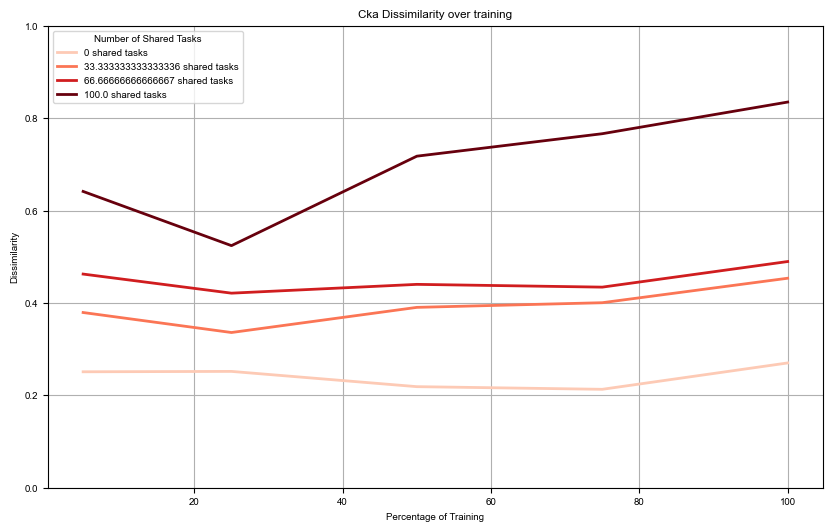

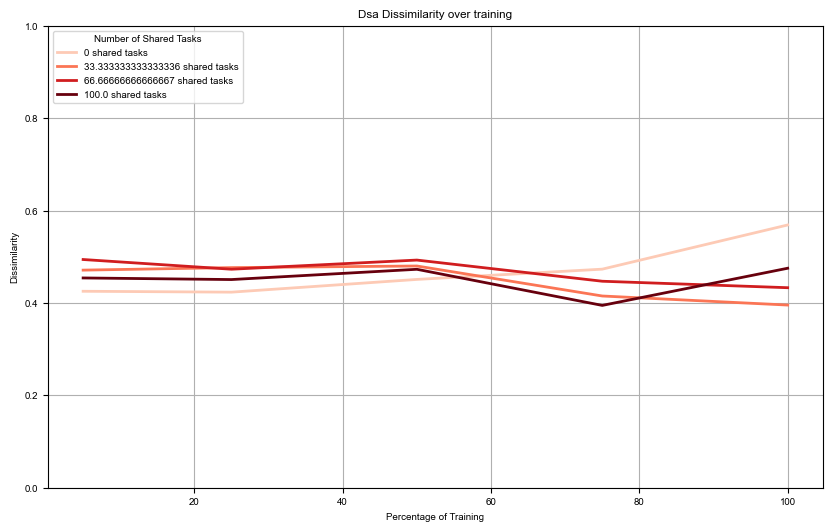

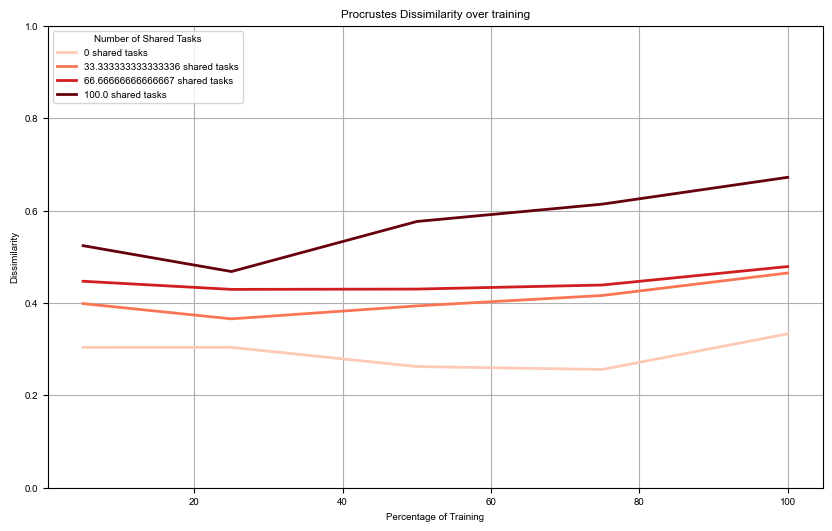

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Normalize the number of shared tasks to range between a small positive value and 1 for color mapping
all_shared_tasks = [shared for measure in diss_cc for shared in diss_cc[measure]]
min_shared = min(all_shared_tasks)
max_shared = max(all_shared_tasks)

# Set a small offset to avoid using the lightest color for 0 shared tasks
offset = 0.2  # This will push the normalization slightly to the right

# Create a colormap ranging from light to dark red
cmap = cm.Reds

# Plot each measure
for measure in diss_cc:
    plt.figure(figsize=(10, 6))  # Create a new figure for each measure
    handles = []
    labels = []

    for shared in sorted(
        diss_cc[measure].keys()
    ):  # Sort by shared tasks for plotting and legend ordering
        x_new, y_new = diss_cc[measure][shared]

        # Normalize shared task count to get a color, with the offset to avoid very light colors
        norm_shared = offset + (shared - min_shared) / (max_shared - min_shared) * (
            1 - offset
        )
        color = cmap(norm_shared)  # Get the color from the colormap

        # Plot with the determined color
        (line,) = plt.plot(
            [5] + x_new[1:],
            y_new,
            label=f"{shared} shared tasks",
            color=color,
            linewidth=2,
        )
        handles.append(line)
        labels.append(f"{shared} shared tasks")

    # Reorder the legend according to the number of shared tasks
    plt.legend(
        handles=handles, labels=labels, title="Number of Shared Tasks", loc="upper left"
    )

    plt.xlabel("Percentage of Training")
    plt.ylim(0, 1)
    plt.ylabel("Dissimilarity")
    plt.title(f"{measure.capitalize()} Dissimilarity over training")
    plt.grid(True)
    plt.show()

In [ ]:
group_pairs_master

{100.0: [('master', 'pretrain_frozen')],
 33.333333333333336: [('master', 'pretrain_basic_frozen'),
  ('master', 'pretrain_anti_frozen'),
  ('master', 'pretrain_delay_frozen')],
 66.66666666666667: [('master', 'pretrain_basic_anti_frozen'),
  ('master', 'pretrain_basic_delay_frozen')],
 0: [('master', 'master_frozen')]}

### Dissimilarity within group 

In [ ]:
path = f"../data/dissimilarities_within_learning_averaged_curves_50_1/mamba/{taskset}/master"
measures = ['cka','dsa','procrustes']
dissimilarities = {measure:[] for measure in measures}


for measure in measures:
    path_measure = os.path.join(path, measure)
    files = os.listdir(path_measure)
    for file in files:
        file_path = os.path.join(path_measure, file)
        if "mamba_8" in file_path:
            if file_path.endswith(".npz"):
                with np.load(file_path) as data:
                    dissimilarities[measure].append(data["arr_0"])
# Function to check if any non-diagonal element is less than the threshold
def has_small_non_diagonal_elements(arr, threshold=1e-10):
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            if i != j and arr[i, j] < threshold:
                return True
    return False
for (
    measure,
    value,
) in dissimilarities.items():  # Stack the arrays along a new axis (axis 0)
    dissimilarities[measure] = [
        arr for arr in value if not has_small_non_diagonal_elements(arr)
    ]
for (
    measure,
    value,
) in dissimilarities.items():  # Stack the arrays along a new axis (axis 0)
    dissimilarities[measure] = np.nanmedian(np.stack(value, axis=0), axis=0)

/var/folders/rg/xgkyjs4945d6ckms1nn6v0jm0000gn/T/ipykernel_3827/1070968890.py:33: RuntimeWarning: All-NaN slice encountered
  dissimilarities[measure] = np.nanmedian(np.stack(value, axis=0), axis=0)


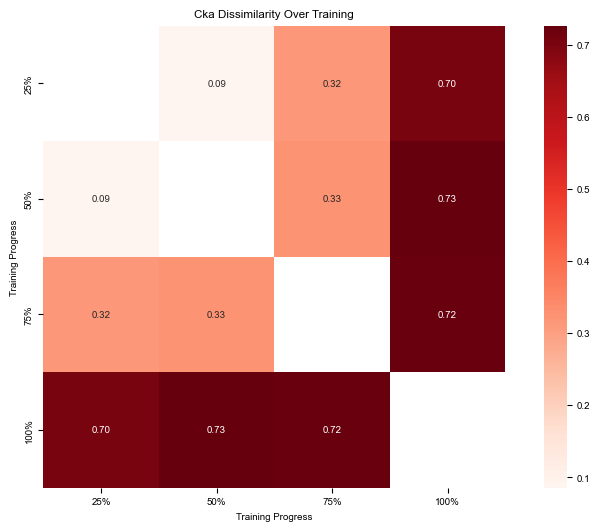

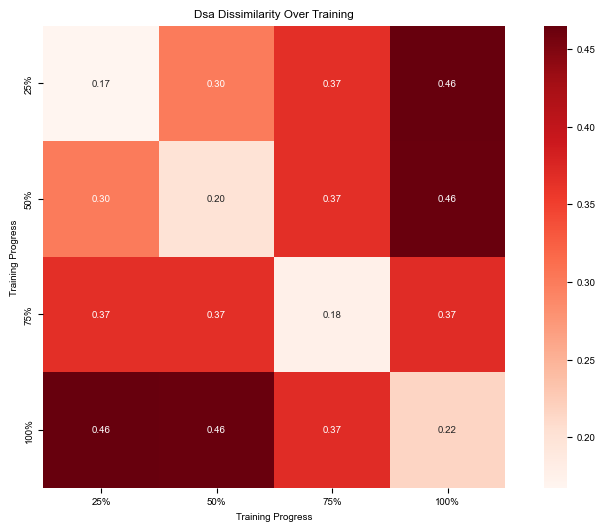

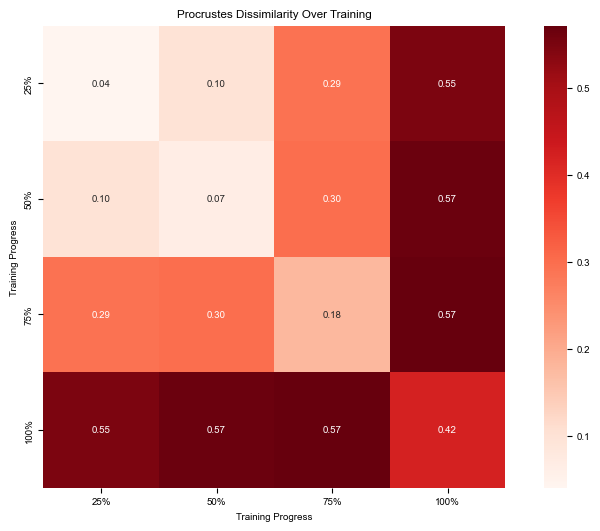

In [ ]:
# Percentage labels to use instead of indices
percent_labels = ["25%", "50%", "75%", "100%"]

for measure, value in dissimilarities.items():
    # Create the heatmap
    plt.figure(figsize=(10, 6))
    ax = sns.heatmap(value, annot=True, cmap="Reds", cbar=True, square=True, fmt=".2f")

    # Set the percentage labels on the x and y axes
    ax.set_xticklabels(percent_labels)
    ax.set_yticklabels(percent_labels)

    # Set axis labels
    ax.set_xlabel("Training Progress")
    ax.set_ylabel("Training Progress")

    # Set the title
    plt.title(f"{measure.capitalize()} Dissimilarity Over Training")

    # Show the plot
    plt.show()